In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import lsq_linear
from sklearn.linear_model import LinearRegression
import pickle
import seaborn as sns
from datetime import date

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline 

## Configuration

### Plotting styling

In [36]:
colors = {}
#Expert algos
colors['Threshold0'] = 'black'
colors['AElphe2'] = 'tab:green'
colors['AEtele2'] = 'tab:orange'
colors['AEmse'] = 'tab:blue'

styles = {}
styles['Threshold0'] = '-'
styles['AElphe2'] = '-'
styles['AEtele2'] = '-'
styles['AEmse'] = '-'

legends = {}
legends['Threshold0'] = 'All trigger cells'
legends['AElphe2'] = 'EMD NN loss'
legends['AEtele2'] = 'Telescope loss'
legends['AEmse'] = 'Weighted MSE loss'

### Input files and FE algorithms to be studied
Both 200PU electron gun and 0PU photon guns are loaded

In [5]:
#Make new image directory for today's updates

today = date.today().strftime("%m_%d_%y")

fig_dir=os.path.join('/ecoderemdvol/paper_plots/{}/physics/').format(today)

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [6]:
algo_files = {}

# Read  old FE set
directory = '/ecoderemdvol/paper_plots/physics_data/11_17_22_paper_mse/'
fes = ['Threshold0','AEtele2','AElphe2','AEmse']
for fe in fes:
    algo_files[fe] = (glob(directory+'/electrons/*.hdf5'), glob(directory+'/photons/*.hdf5'))

## Loading and preprocessing dataframes

In [21]:
algos_dfs = {}
for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files[0]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    for file in files[1]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    algos_dfs[fe] = pd.concat(dfs)
algo_names = sorted(algos_dfs.keys())


KeyboardInterrupt



Selection cuts (in addition to those already applied before):
- Gen particle $p_T > 5 GeV$
- Cluster $p_T > 3 GeV$
- Extrapolated gen particle eta between 1.6 and 2.9

Additionally label electrons and positrons as `0` and photons as `1`.

In [22]:
ptcut=5
clptcut=3
etamin=1.6
etamax=2.9
algo_cut={}
for name,df in algos_dfs.items():
    sel = df['genpart_pt']>ptcut
    algo_cut[name] = df[sel]
    sel = algo_cut[name]['cl3d_pt']>clptcut
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])>etamin
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])<etamax
    algo_cut[name] = algo_cut[name][sel]
    sel = algo_cut[name]['matches']==True
    algo_cut[name] = algo_cut[name][sel]
    #algo_cut[name].dropna(inplace=True)
    algo_cut[name]['genpart_pid'].replace([-11,11],1, inplace=True)
    algo_cut[name]['genpart_pid'].replace([22],0, inplace=True)

In [9]:
for name,df in algo_cut.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)

## Energy corrections
### Layer weights
On 0PU photon clusters:
- Select layer pTs in the ECAL, dropping the first layer as it doesn't bring anything in the e/g energy and is polluted by PU
- Apply linear regression to find multiplicative coeff. to be applied to each layer pT. These coeff. are bounded between 0 and 2 to avoid large correction factors

In [10]:
layer_coeffs = {}
for name,df in algo_cut.items():
    print(name)
    # select layers [2,14]
    select = df.query('genpart_pid==0')
    layers = np.array(select['cl3d_layer_pt'].tolist())[:,2:15]
    regression = lsq_linear(layers, select['genpart_pt'],
                              bounds = (0.,2.0),
                              method='bvls',
                              lsmr_tol='auto',
                              verbose=1)
    layer_coeffs[name] = regression.x
    print(regression.x)

Threshold0
The relative change of the cost function is less than `tol`.
Number of iterations 3, initial cost 1.1619e+05, final cost 1.0867e+05, first-order optimality 2.38e-08.
[1.55111097 0.94607044 1.03193246 1.04884556 1.00940715 1.07910901
 1.0505931  1.00680063 0.95738608 0.85157079 1.01670185 1.96904214
 2.        ]
AEtele2
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 1.7710e+05, final cost 1.6980e+05, first-order optimality 4.56e-09.
[1.64644941 1.04951918 1.12595881 1.14295197 1.08594173 1.1393935
 1.1513369  1.08523395 1.02202807 0.92657328 1.29459988 2.
 2.        ]
AElphe2
The relative change of the cost function is less than `tol`.
Number of iterations 3, initial cost 1.3695e+05, final cost 1.2973e+05, first-order optimality 2.27e-08.
[1.57637865 0.99296236 1.04308052 1.07969332 1.02105159 1.09131539
 1.07997478 1.03648239 0.9682921  0.86145071 1.09438354 1.95757564
 2.        ]
AEmse
The relative change of the cost funct

Apply layer weights and compute ratios wrt the gen $p_T$ and plot the weight values

In [11]:
# Apply calibration
for name,df in algo_cut.items():
    layers = np.array(df['cl3d_layer_pt'].tolist())[:,2:15]
    df['cl3d_pt_calib'] = np.dot(layers, layer_coeffs[name])
    df['cl3d_over_gen_pt'] = df['cl3d_pt']/df['genpart_pt']
    df['calib_over_gen_pt'] = df['cl3d_pt_calib']/df['genpart_pt']

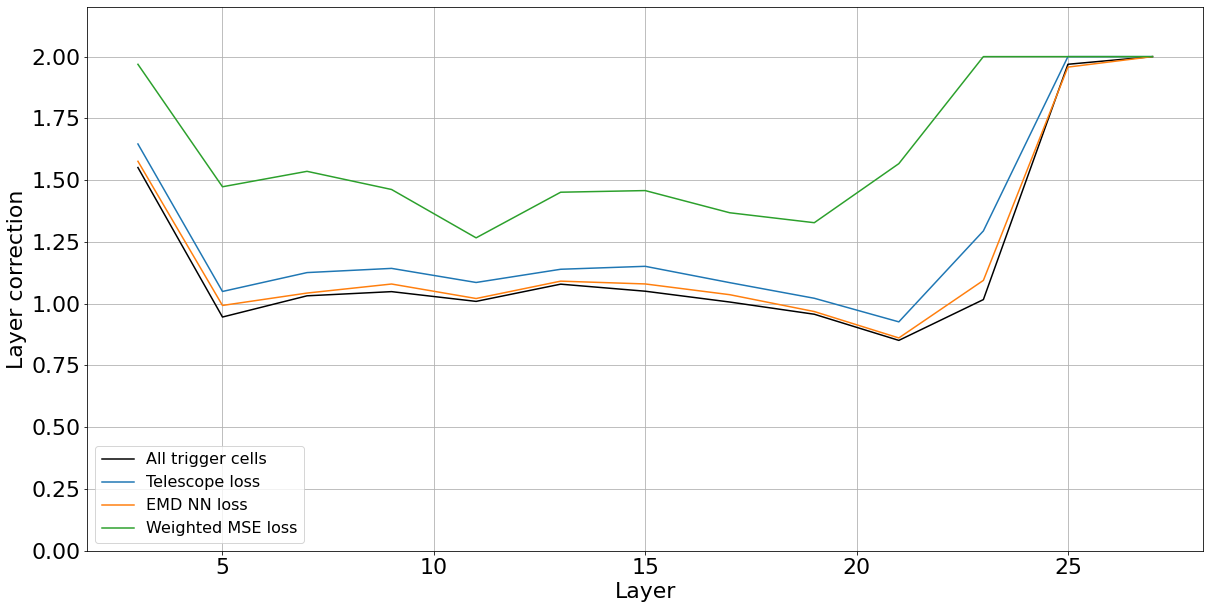

In [12]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
for name,weights in layer_coeffs.items():
    plt.plot(range(3, 29, 2), weights, label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0., 2.2)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('Layer')
plt.ylabel('Layer correction')
plt.show()

Check impact of layer corrections on the energy ratio distributions

Raw mean=0.960659921169281, rms=0.036352161318063736, rms/mean=0.03784082224833236
Calib mean=0.998154828477221, rms=0.0412746383015207, rms/mean=0.041350937874526976


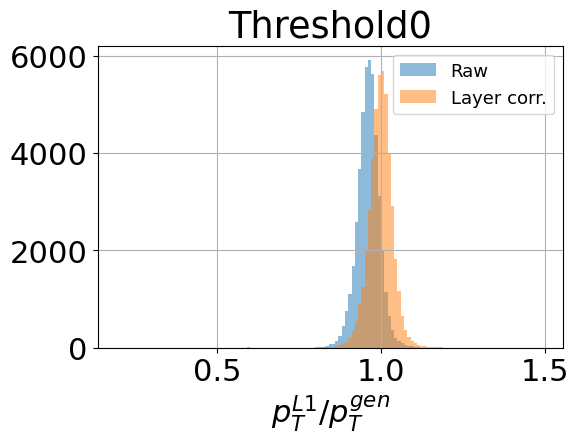

Raw mean=0.8859699964523315, rms=0.04152195528149605, rms/mean=0.046866096422860166
Calib mean=0.9960940244748465, rms=0.04933712249199589, rms/mean=0.0495305877555154


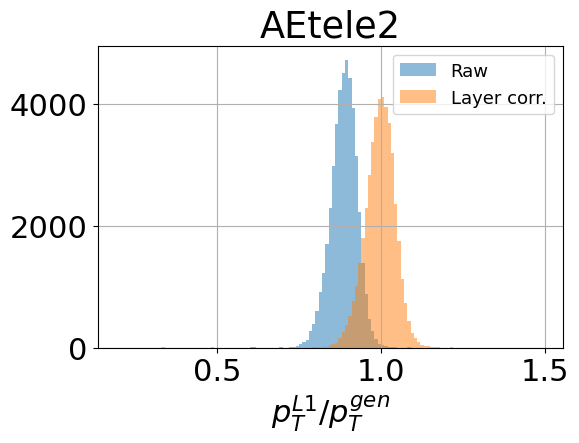

Raw mean=0.9386988878250122, rms=0.038873184472322464, rms/mean=0.04141177216305493
Calib mean=0.9952639288655879, rms=0.04426243472896193, rms/mean=0.04447306231565401


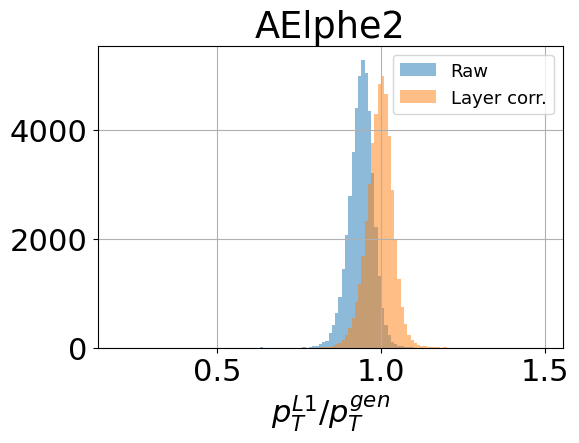

Raw mean=0.6921845078468323, rms=0.05609576404094696, rms/mean=0.08104163471592739
Calib mean=0.9955872068888079, rms=0.08222536618852623, rms/mean=0.08258981796831141


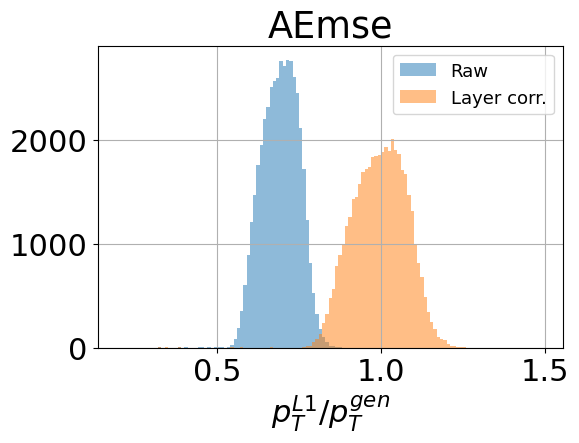

In [13]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==0')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Raw')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Layer corr.')
    plt.title(name)
    plt.legend(fontsize=13)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.grid()
    plt.show()

## eta correction
On 200PU electrons, on top of the layer correction.

Simple linear correction vs eta to correct for PU. This correction is additive, not multiplicative.

In [14]:
corrs = {}
corrs['eta'] = {}
for name,df in algo_cut.items():
    print('  '+name)
    select = df.query('genpart_pid==1')
    X = select[['cl3d_abseta']]
    y = select['genpart_pt']-select['cl3d_pt_calib']
    corrs['eta'][name] = LinearRegression().fit(X, y)

  Threshold0
  AEtele2
  AElphe2
  AEmse


Print correction value at eta=1.5 and eta=3

In [15]:
for name,df in algo_cut.items():
    corr = corrs['eta'][name]
    print(name)
    print('  eta=1.5:', corr.intercept_+corr.coef_*1.5)
    print('  eta=3:', corr.intercept_+corr.coef_*3)

Threshold0
  eta=1.5: [5.047944]
  eta=3: [-8.889486]
AEtele2
  eta=1.5: [5.438696]
  eta=3: [-15.114044]
AElphe2
  eta=1.5: [5.0077686]
  eta=3: [-15.224541]
AEmse
  eta=1.5: [5.656187]
  eta=3: [-16.451624]


In [16]:
for name,df in algo_cut.items():
    df['cl3d_corr_eta'] = corrs['eta'][name].predict(df[['cl3d_abseta']])
    df['cl3d_pt_corr_eta'] =  df['cl3d_corr_eta']+df.cl3d_pt_calib
    df['corr_eta_over_gen_pt'] = df['cl3d_pt_corr_eta']/df['genpart_pt']    

Raw mean=1.0221896171569824, rms=0.16356199979782104, rms/mean=0.16001140791542795
Calib mean=1.0474985456283548, rms=0.14115841825104297, rms/mean=0.1347576269582001
Corr eta mean=1.0001410603011345, rms=0.08503609400518336, rms/mean=0.08502410047996597


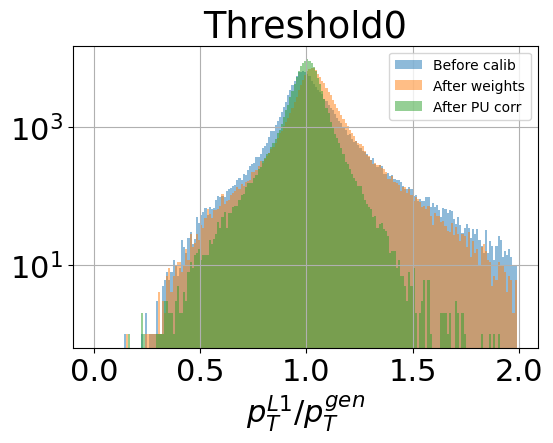

Raw mean=0.9961618781089783, rms=0.18160896003246307, rms/mean=0.18230868297953015
Calib mean=1.1071927587075328, rms=0.1744193053698255, rms/mean=0.15753291736971947
Corr eta mean=0.9862468550214074, rms=0.11092823986454654, rms/mean=0.11247512658698287


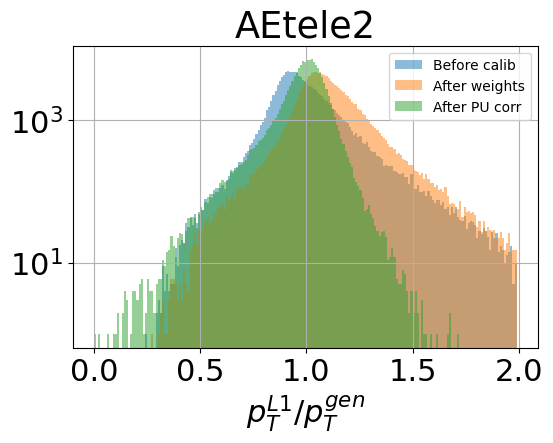

Raw mean=1.0590108633041382, rms=0.18668745458126068, rms/mean=0.17628473989283883
Calib mean=1.1114897990131496, rms=0.16987849794581597, rms/mean=0.15283855784969397
Corr eta mean=0.9833541767339433, rms=0.10838315533169877, rms/mean=0.11021782171269809


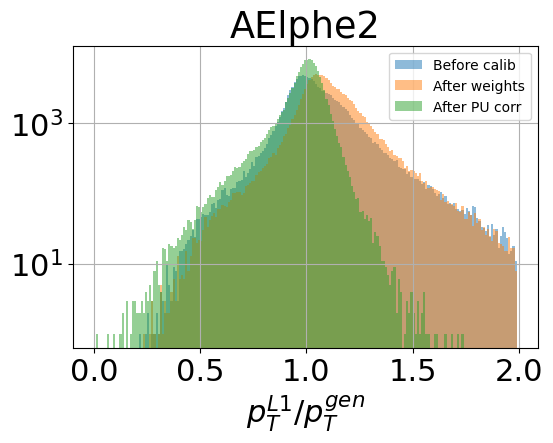

Raw mean=0.7936381101608276, rms=0.17098858952522278, rms/mean=0.21544906593582383
Calib mean=1.1285083131319624, rms=0.20865663743882532, rms/mean=0.18489596843087322
Corr eta mean=0.9929808719486191, rms=0.12223512668711942, rms/mean=0.12309917556341847


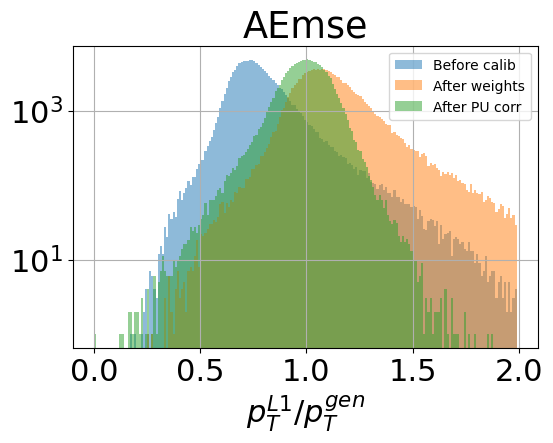

In [17]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    print('Corr eta mean={0}, rms={1}, rms/mean={2}'.format(
        select['corr_eta_over_gen_pt'].mean(),
        select['corr_eta_over_gen_pt'].std(),
        select['corr_eta_over_gen_pt'].std()/select['corr_eta_over_gen_pt'].mean()
    ))
    #plt.figure(figsize=(15,10))
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='Before calib')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After weights')
    plt.hist(select['corr_eta_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After PU corr')
    plt.grid()
    plt.legend(loc = 'upper right', fontsize=10)
    plt.yscale('log')
    plt.title(name)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.show()

## Final plots
### For electrons with 200PU, looking at $p_T > 10\,GeV$
First bin in eta and pT

In [18]:
binetasize = 0.1
binptsize = 5
for name, df in algo_cut.items():
    df['genpart_abseta'] = np.abs(df.genpart_exeta)
    df['genpart_bineta'] = (
        (df.genpart_abseta - etamin)/binetasize).astype('int32')
    df['genpart_binpt'] = (df.genpart_pt/binptsize).astype('int32')

Compute the mean, RMS, and effective RMS of the pT ratios in each eta and pT bin

In [19]:
def effrms(df, c=0.68):
    """Compute half-width of the shortest interval
    containing a fraction 'c' of items in a 1D array.
    """
    out = {}
    for col in df:
        x = df[col]
        x = np.sort(x, kind="mergesort")
        m = int(c * len(x)) + 1
        out[col] = [np.min(x[m:] - x[:-m]) / 2.0]
    return pd.DataFrame(out).iloc[0]

In [20]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {}
both_means={}
both_eff_rms={}
both_full_rms={}
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']


for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    both_means[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).mean()
    both_eff_rms[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).apply(effrms)
    both_full_rms[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).std()

In [37]:
plotted_algo = fes

In [38]:
import mplhep as hep
hep.style.use("CMS")
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

Mean vs eta


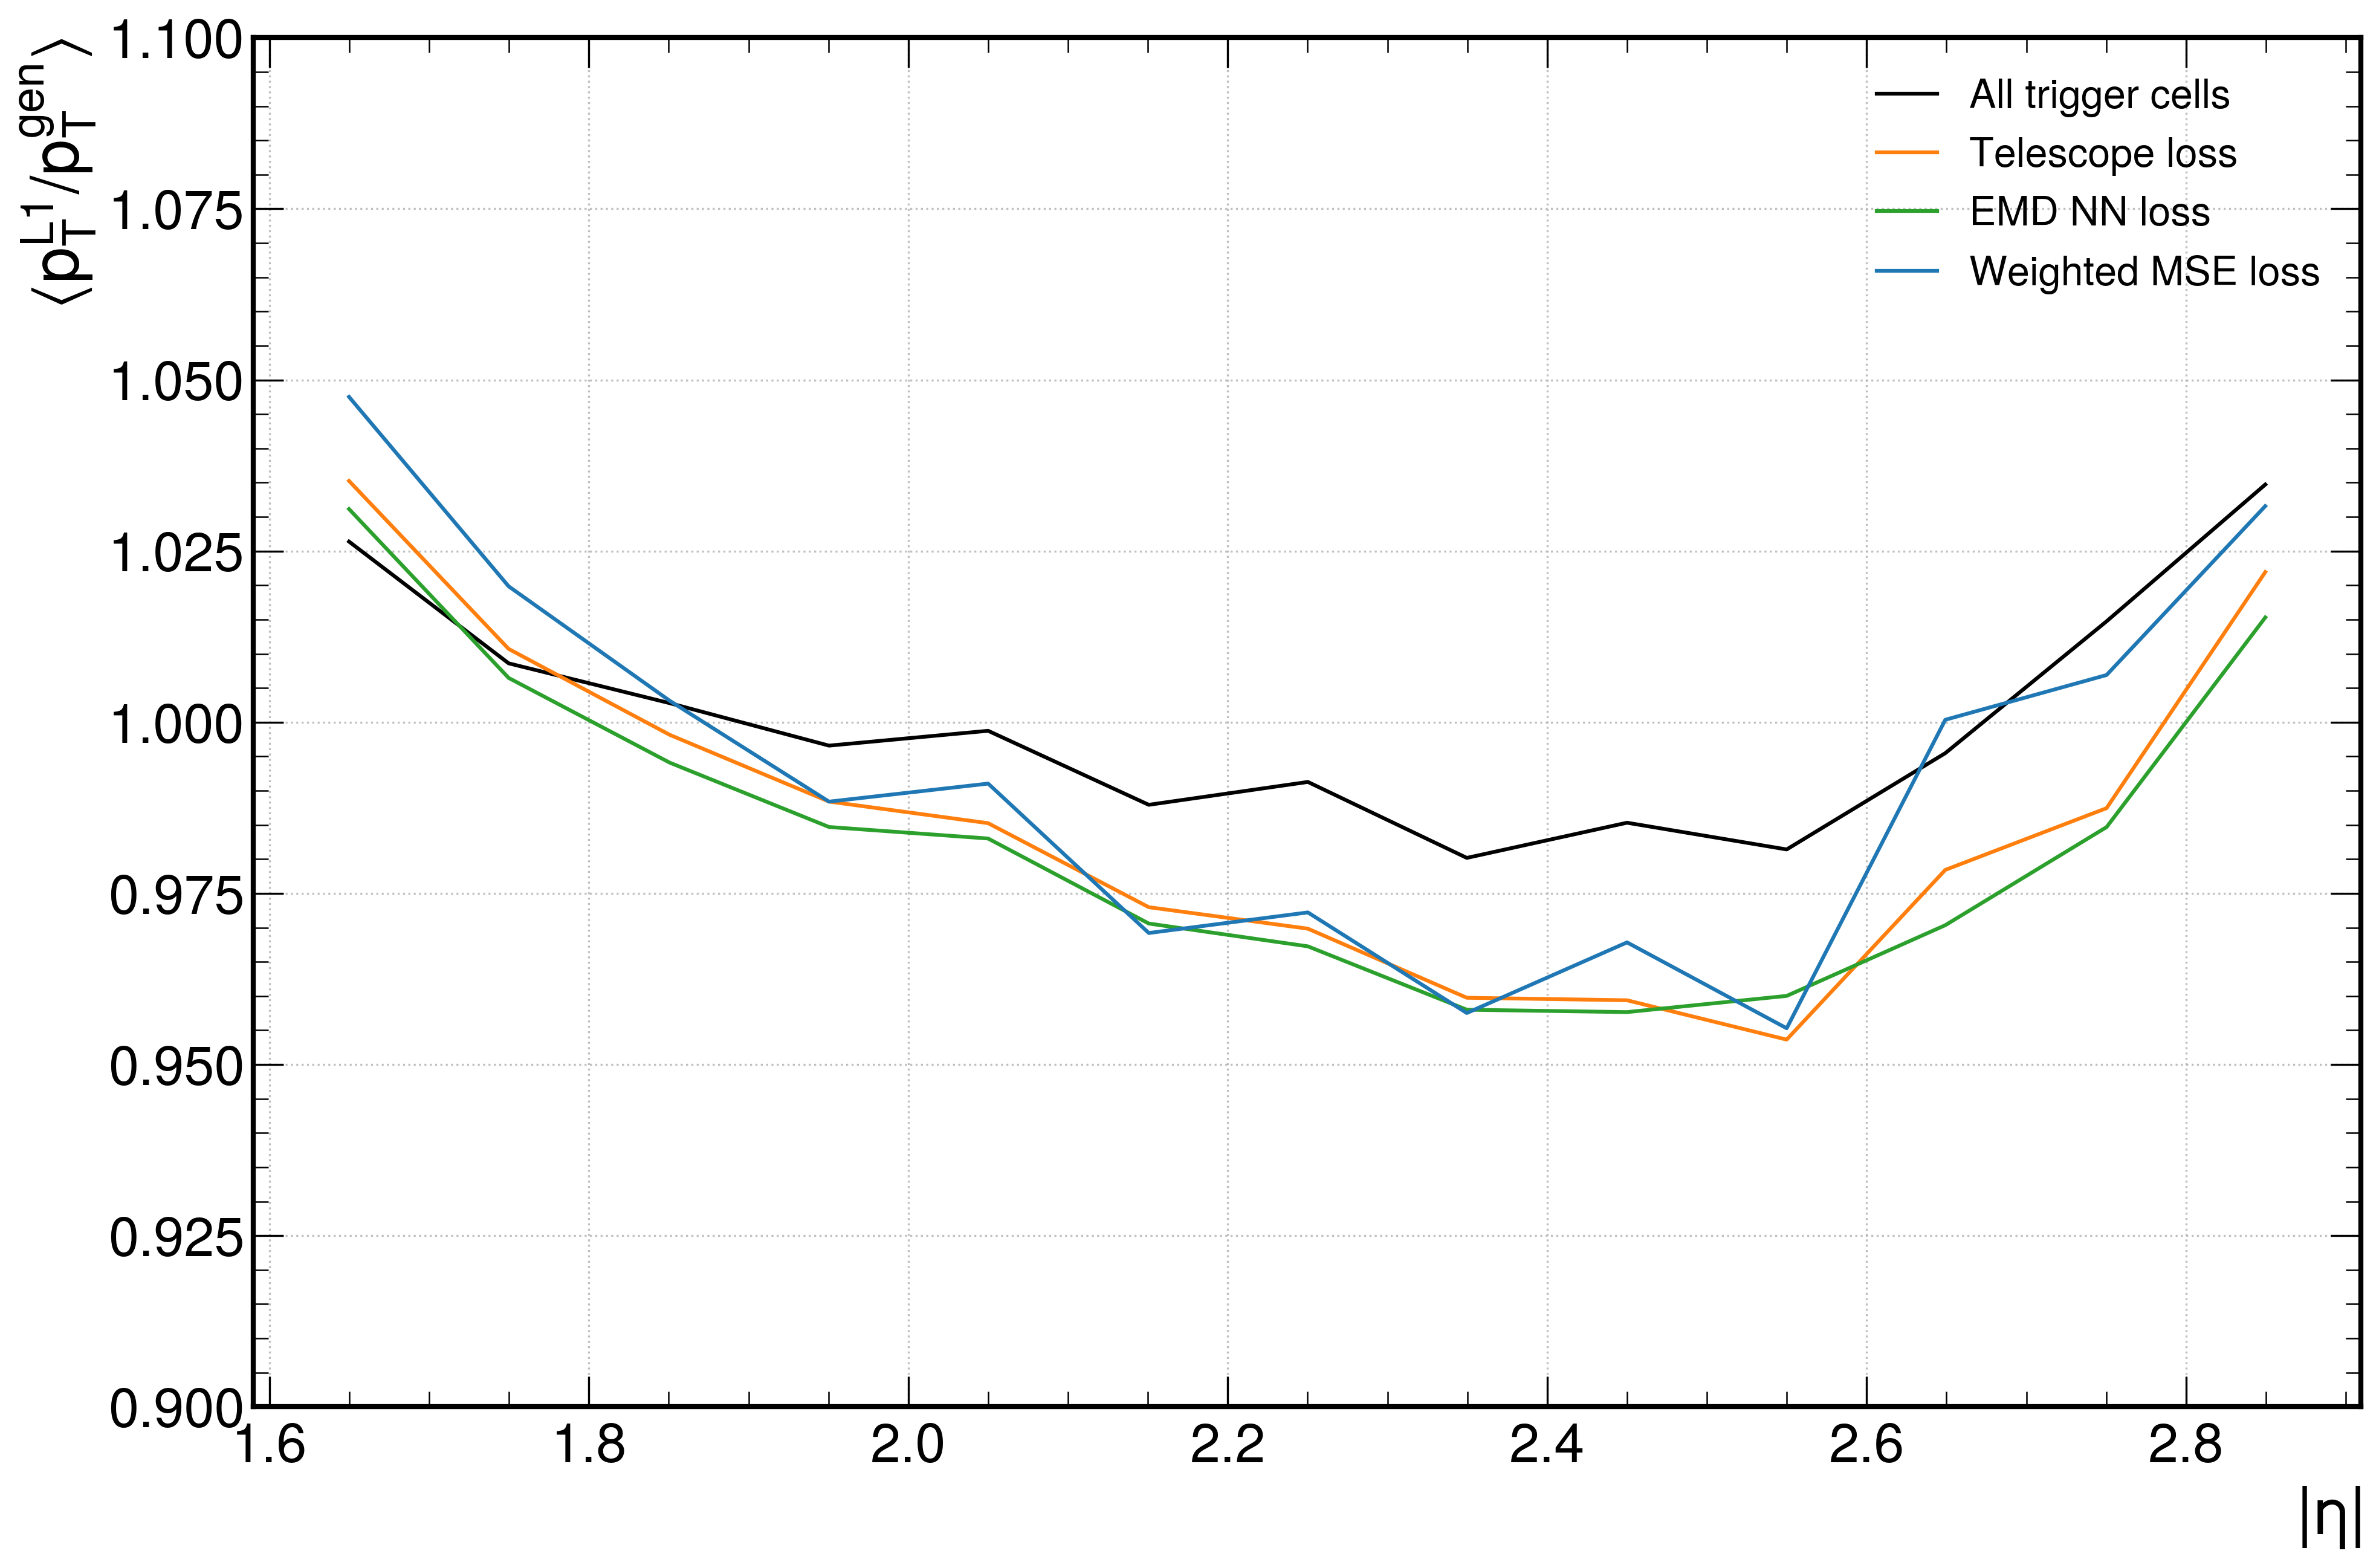

In [39]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
#plt.savefig(fig_dir+'/mean_v_eta.png')
plt.show()

RMS vs eta


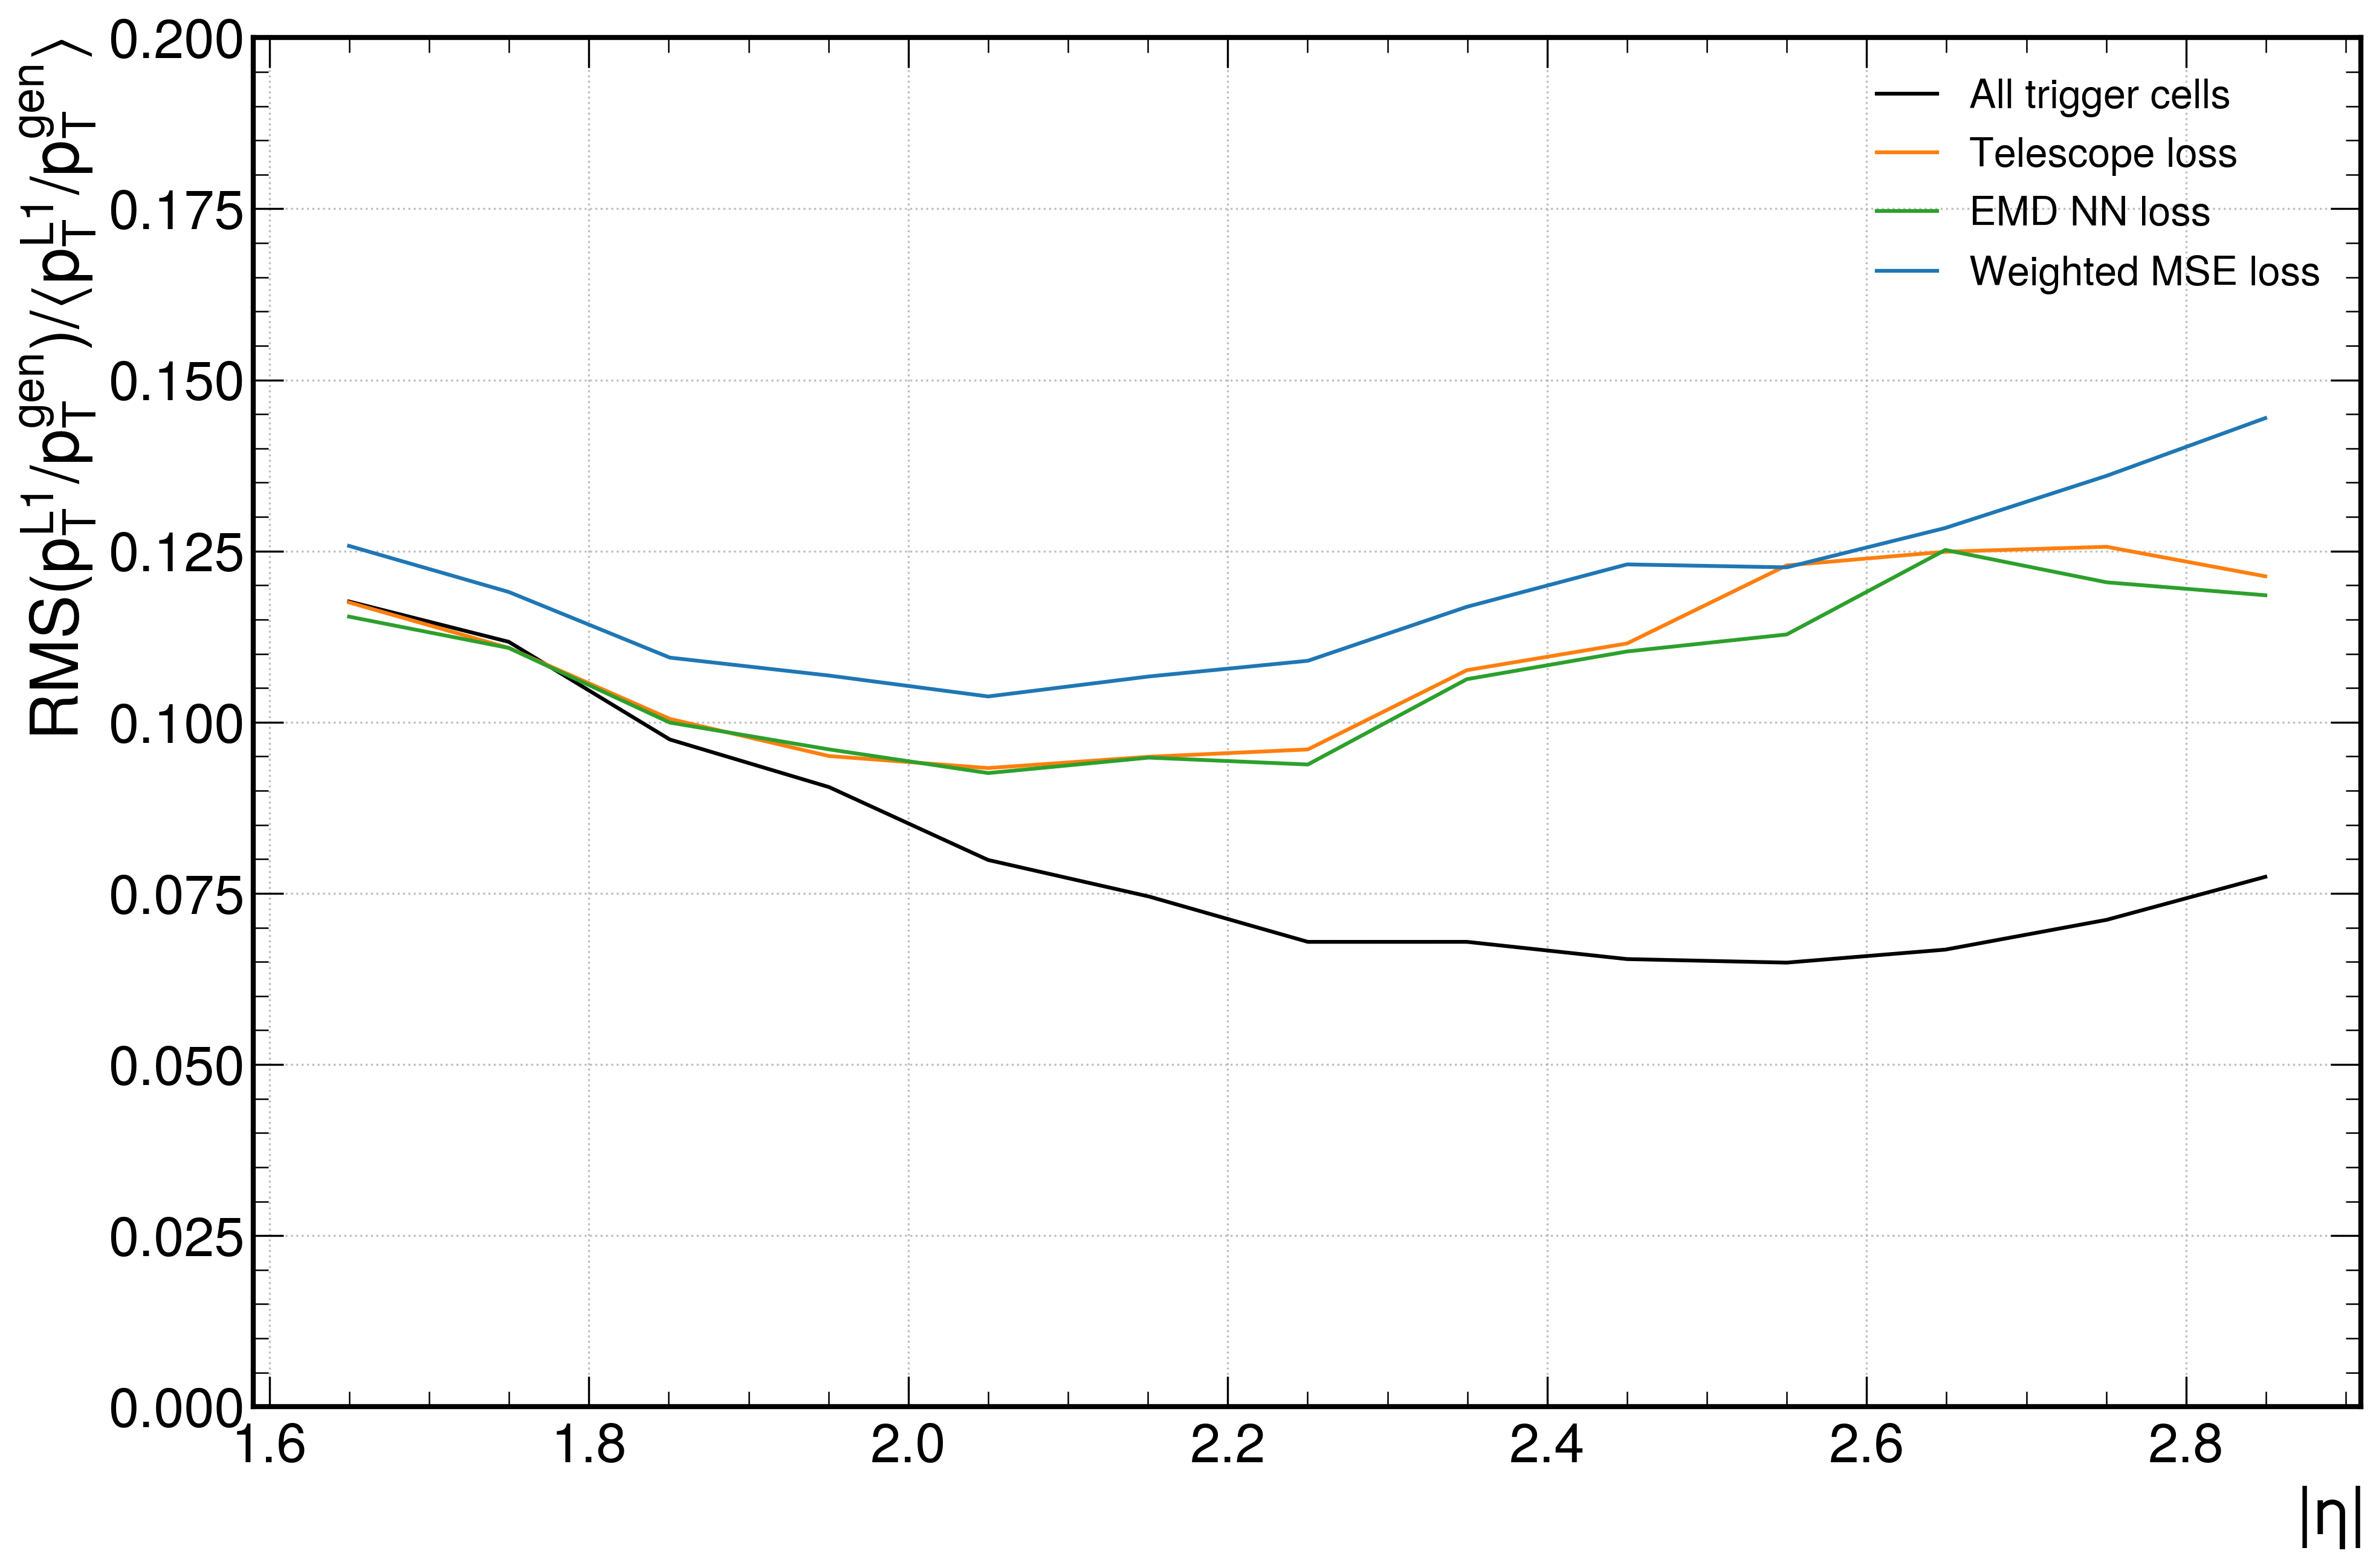

In [40]:
print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
#plt.savefig(fig_dir+'/rms_v_eta.png')
plt.show()

Eff RMS vs eta


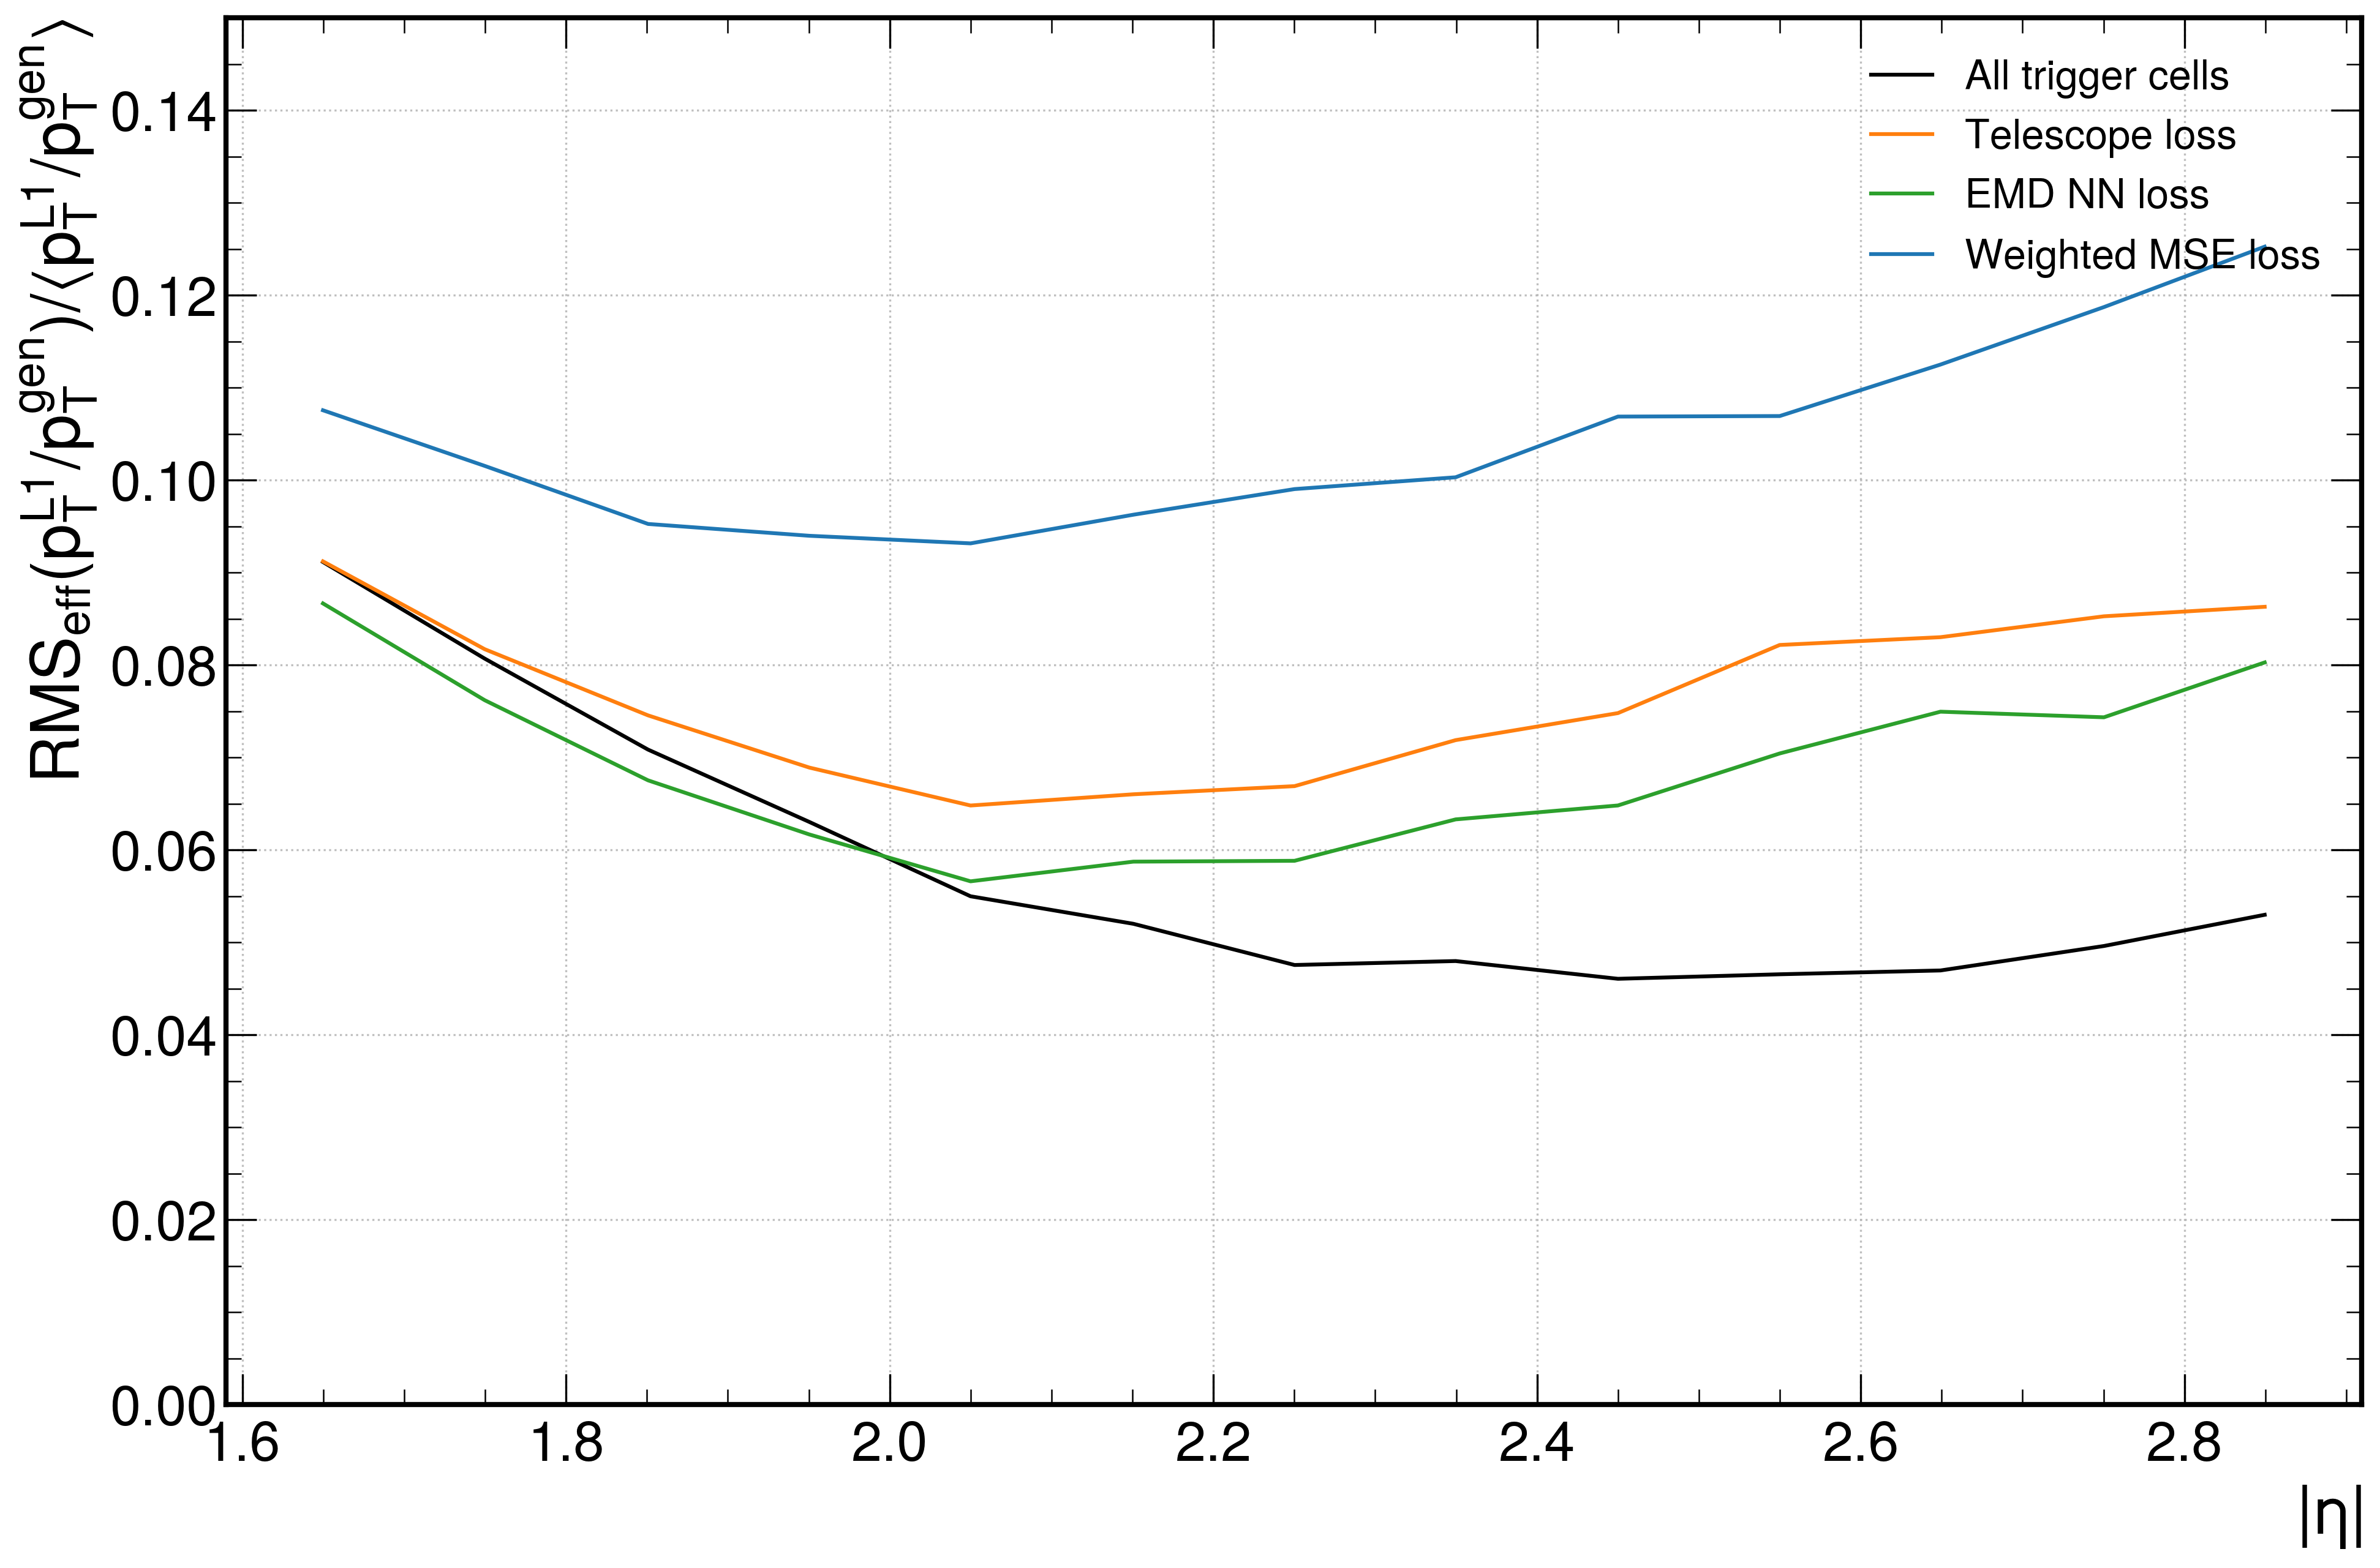

In [41]:
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_eff_v_eta.png')
plt.show()

Mean vs pt


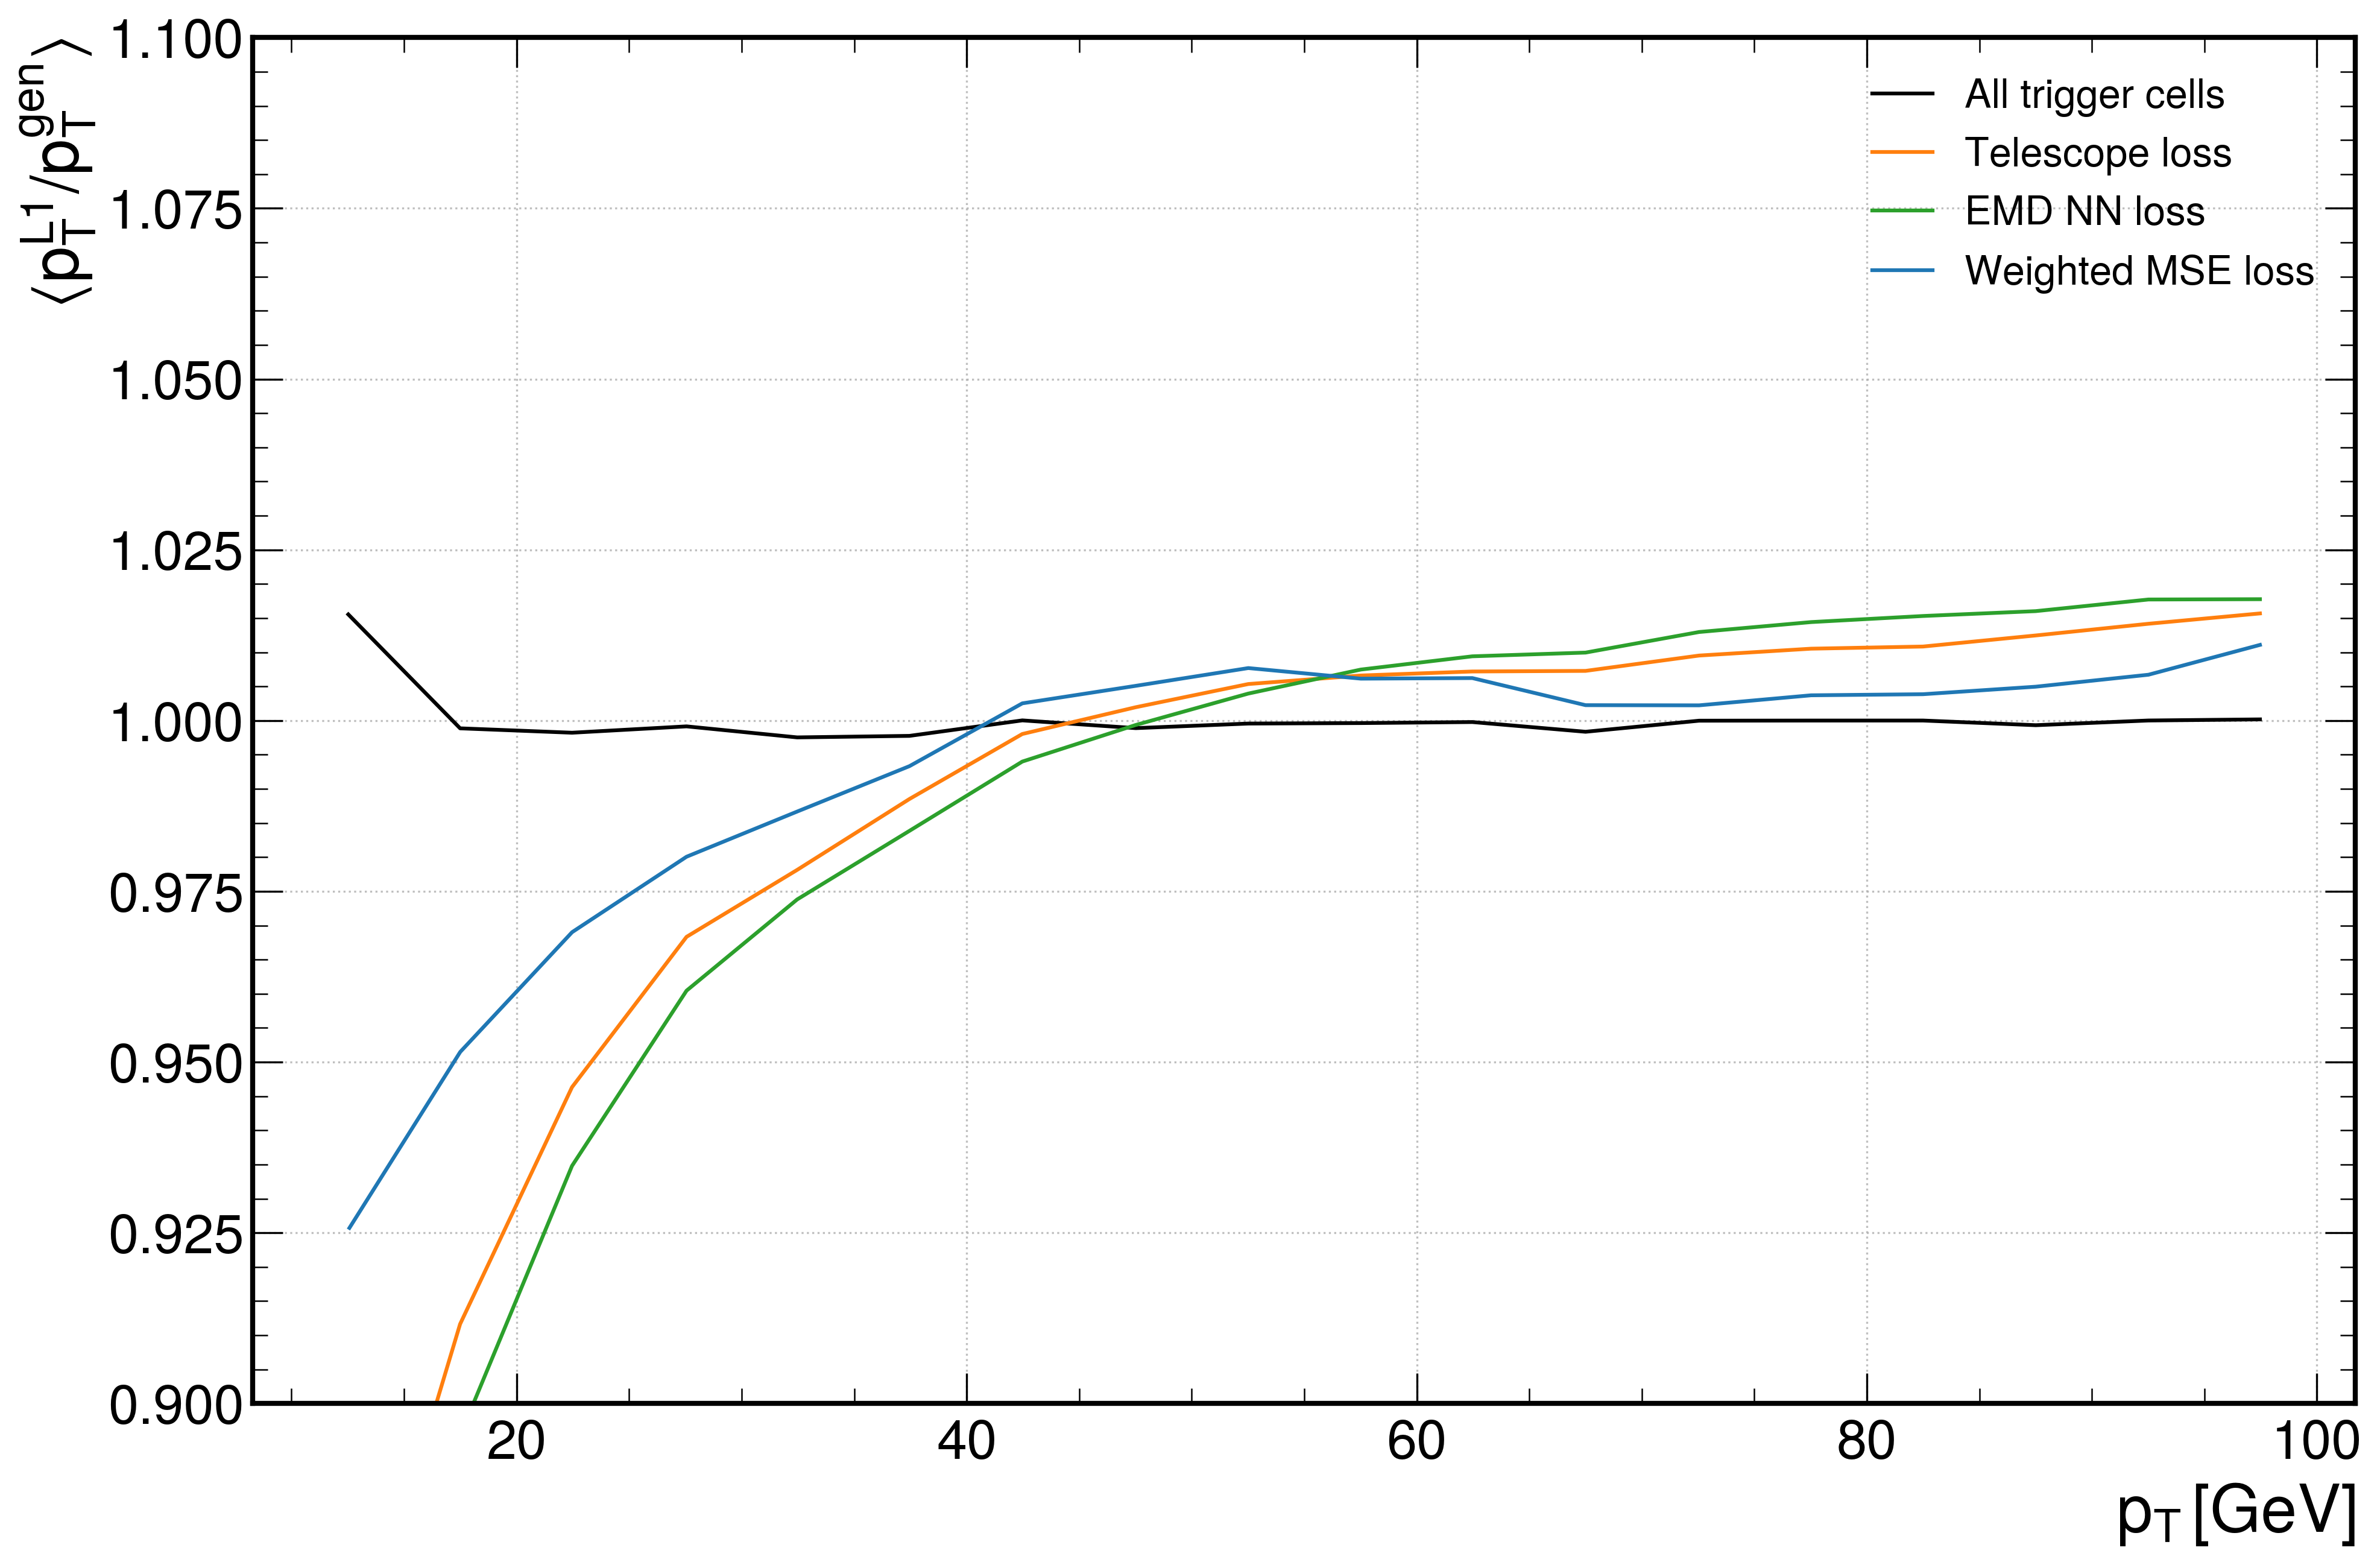

In [42]:
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
#plt.savefig(fig_dir+'/rms_eff_v_eta.png')
plt.show()

RMS vs pt


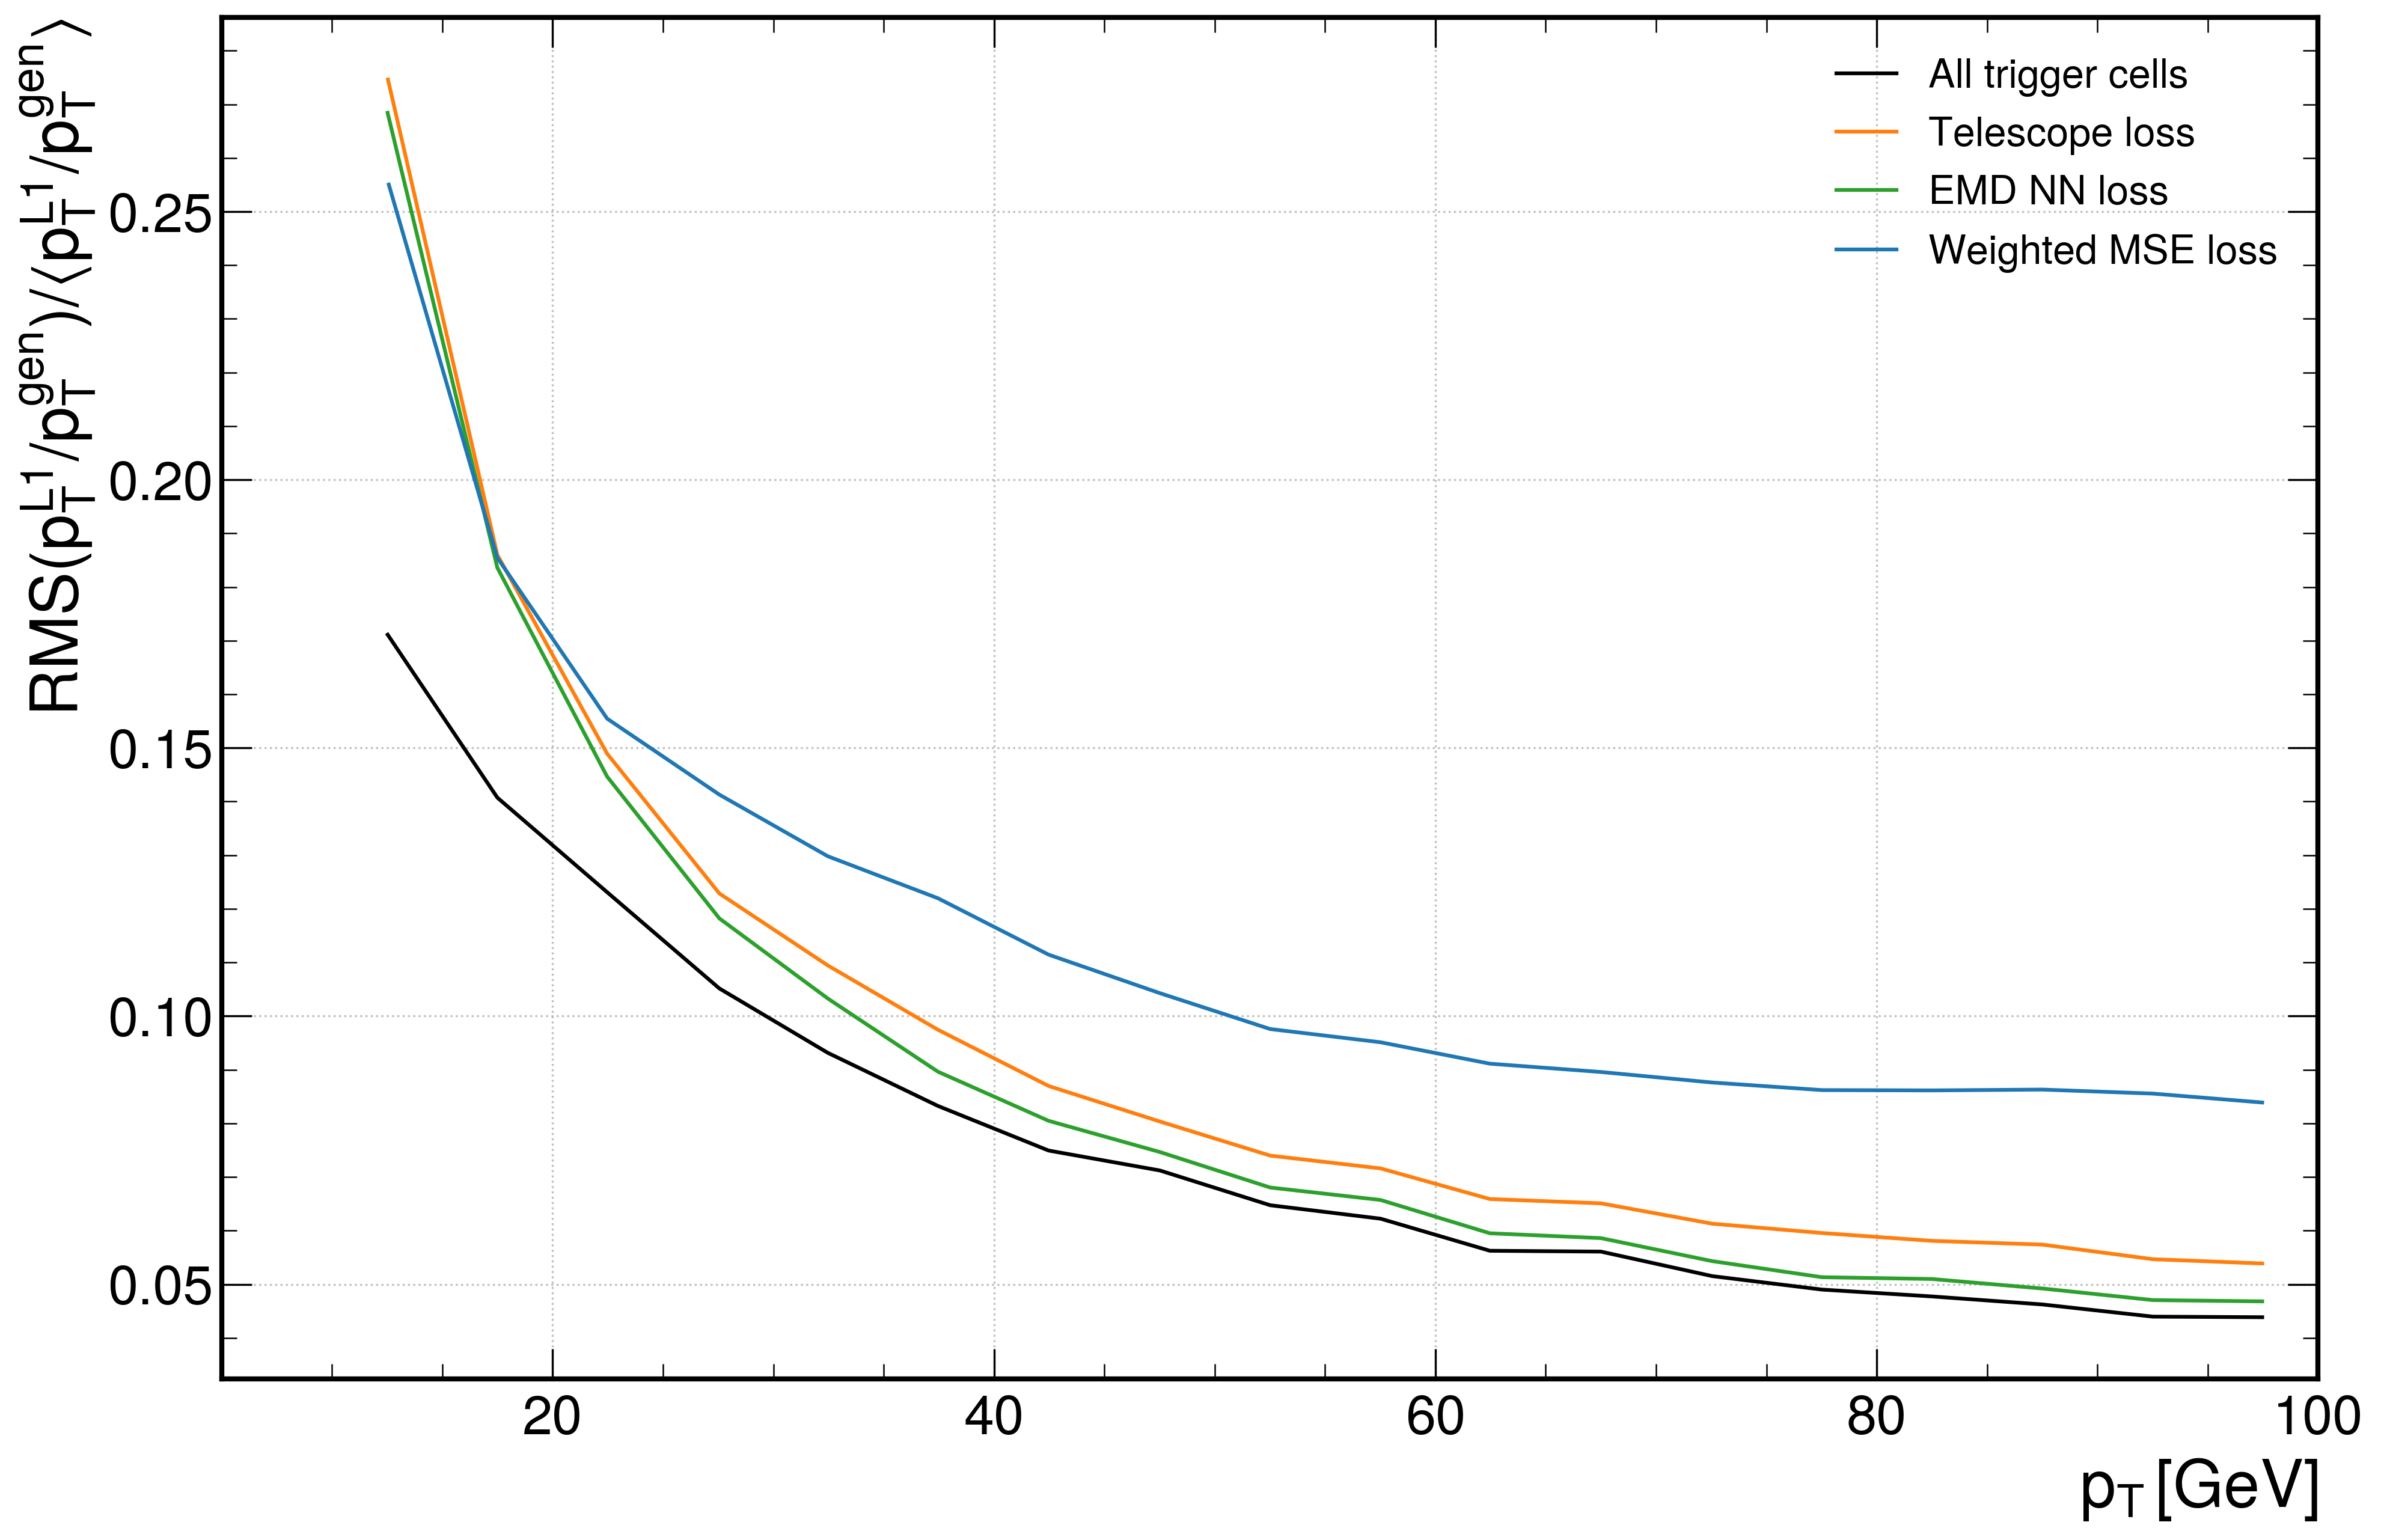

In [43]:
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
#plt.ylim(0., 0.2)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
#plt.savefig(fig_dir+'/rms_v_pT.png')
plt.show()

Eff RMS vs pt


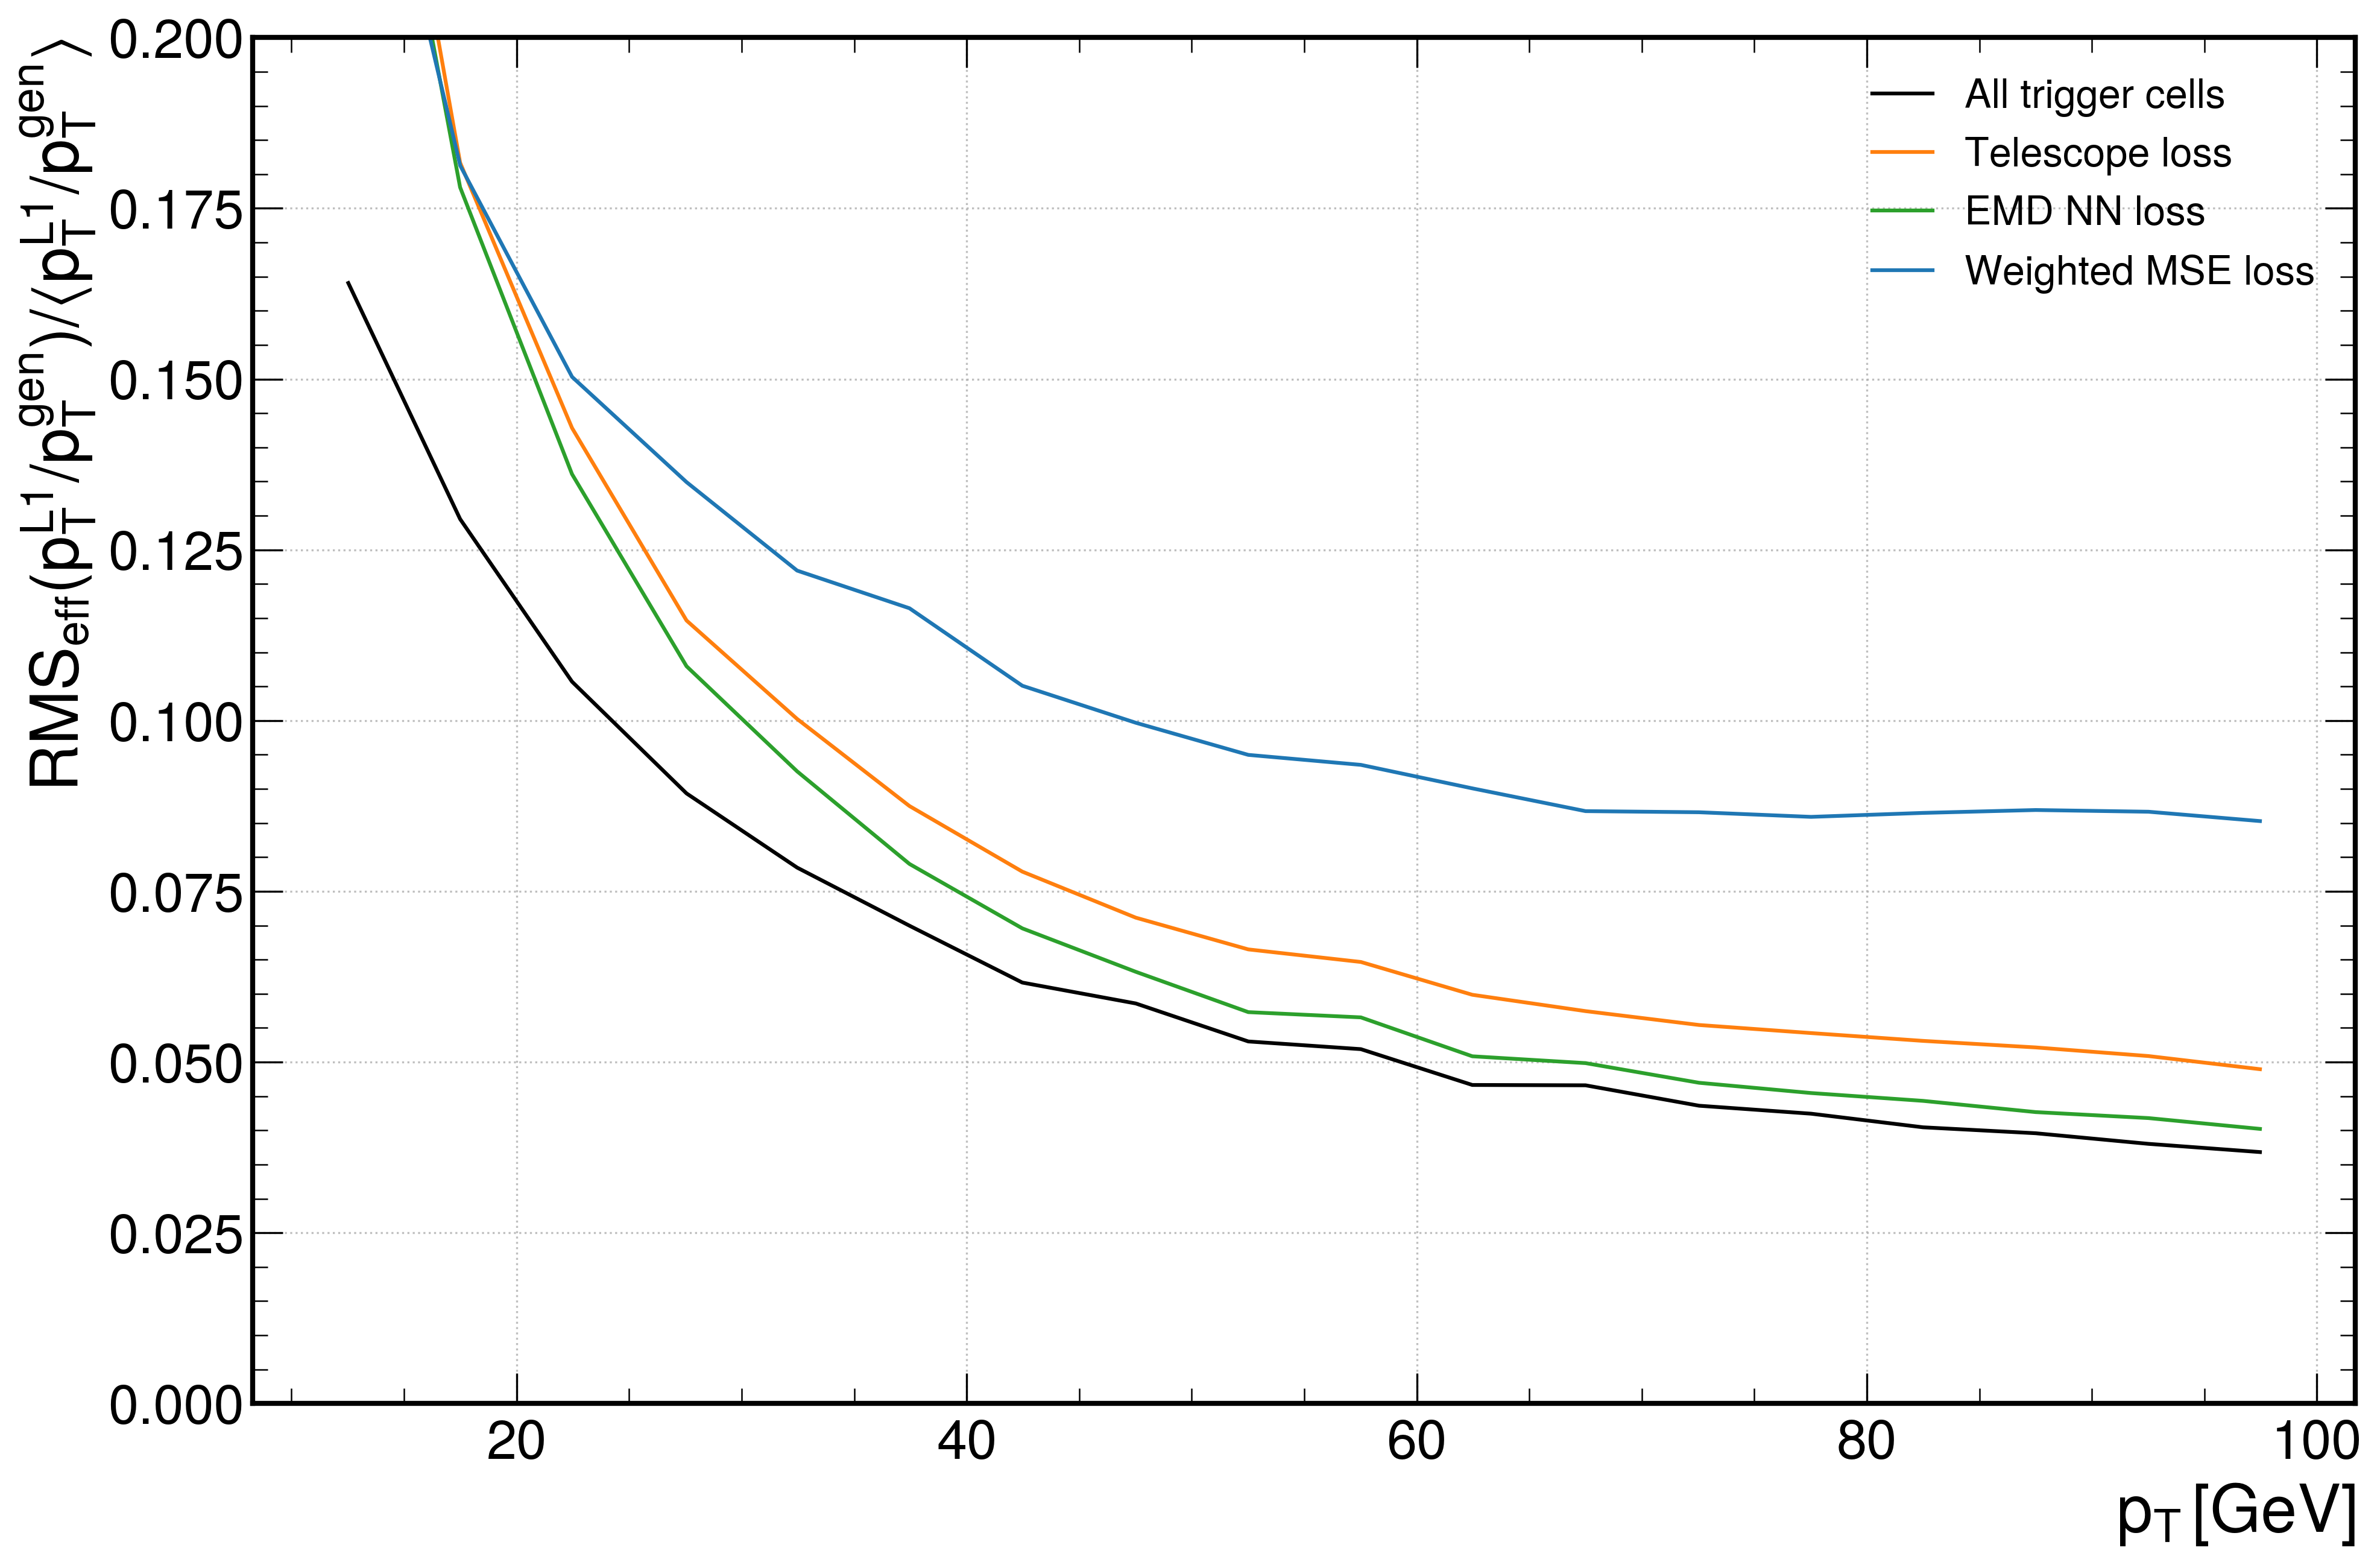

In [44]:
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_eff_v_pT.png')
plt.show()

In [45]:
plotted_algo = ['AEmse','AEtele2','AElphe2']

In [46]:
#Ratio of these plots

DENOM_eta = etaeffrmss['AEmse']['corr_eta_over_gen_pt']/etameans['AEmse']['corr_eta_over_gen_pt']
DENOM_pt = pteffrmss['AEmse']['corr_eta_over_gen_pt']/ptmeans['AEmse']['corr_eta_over_gen_pt']

Relative resolution vs eta


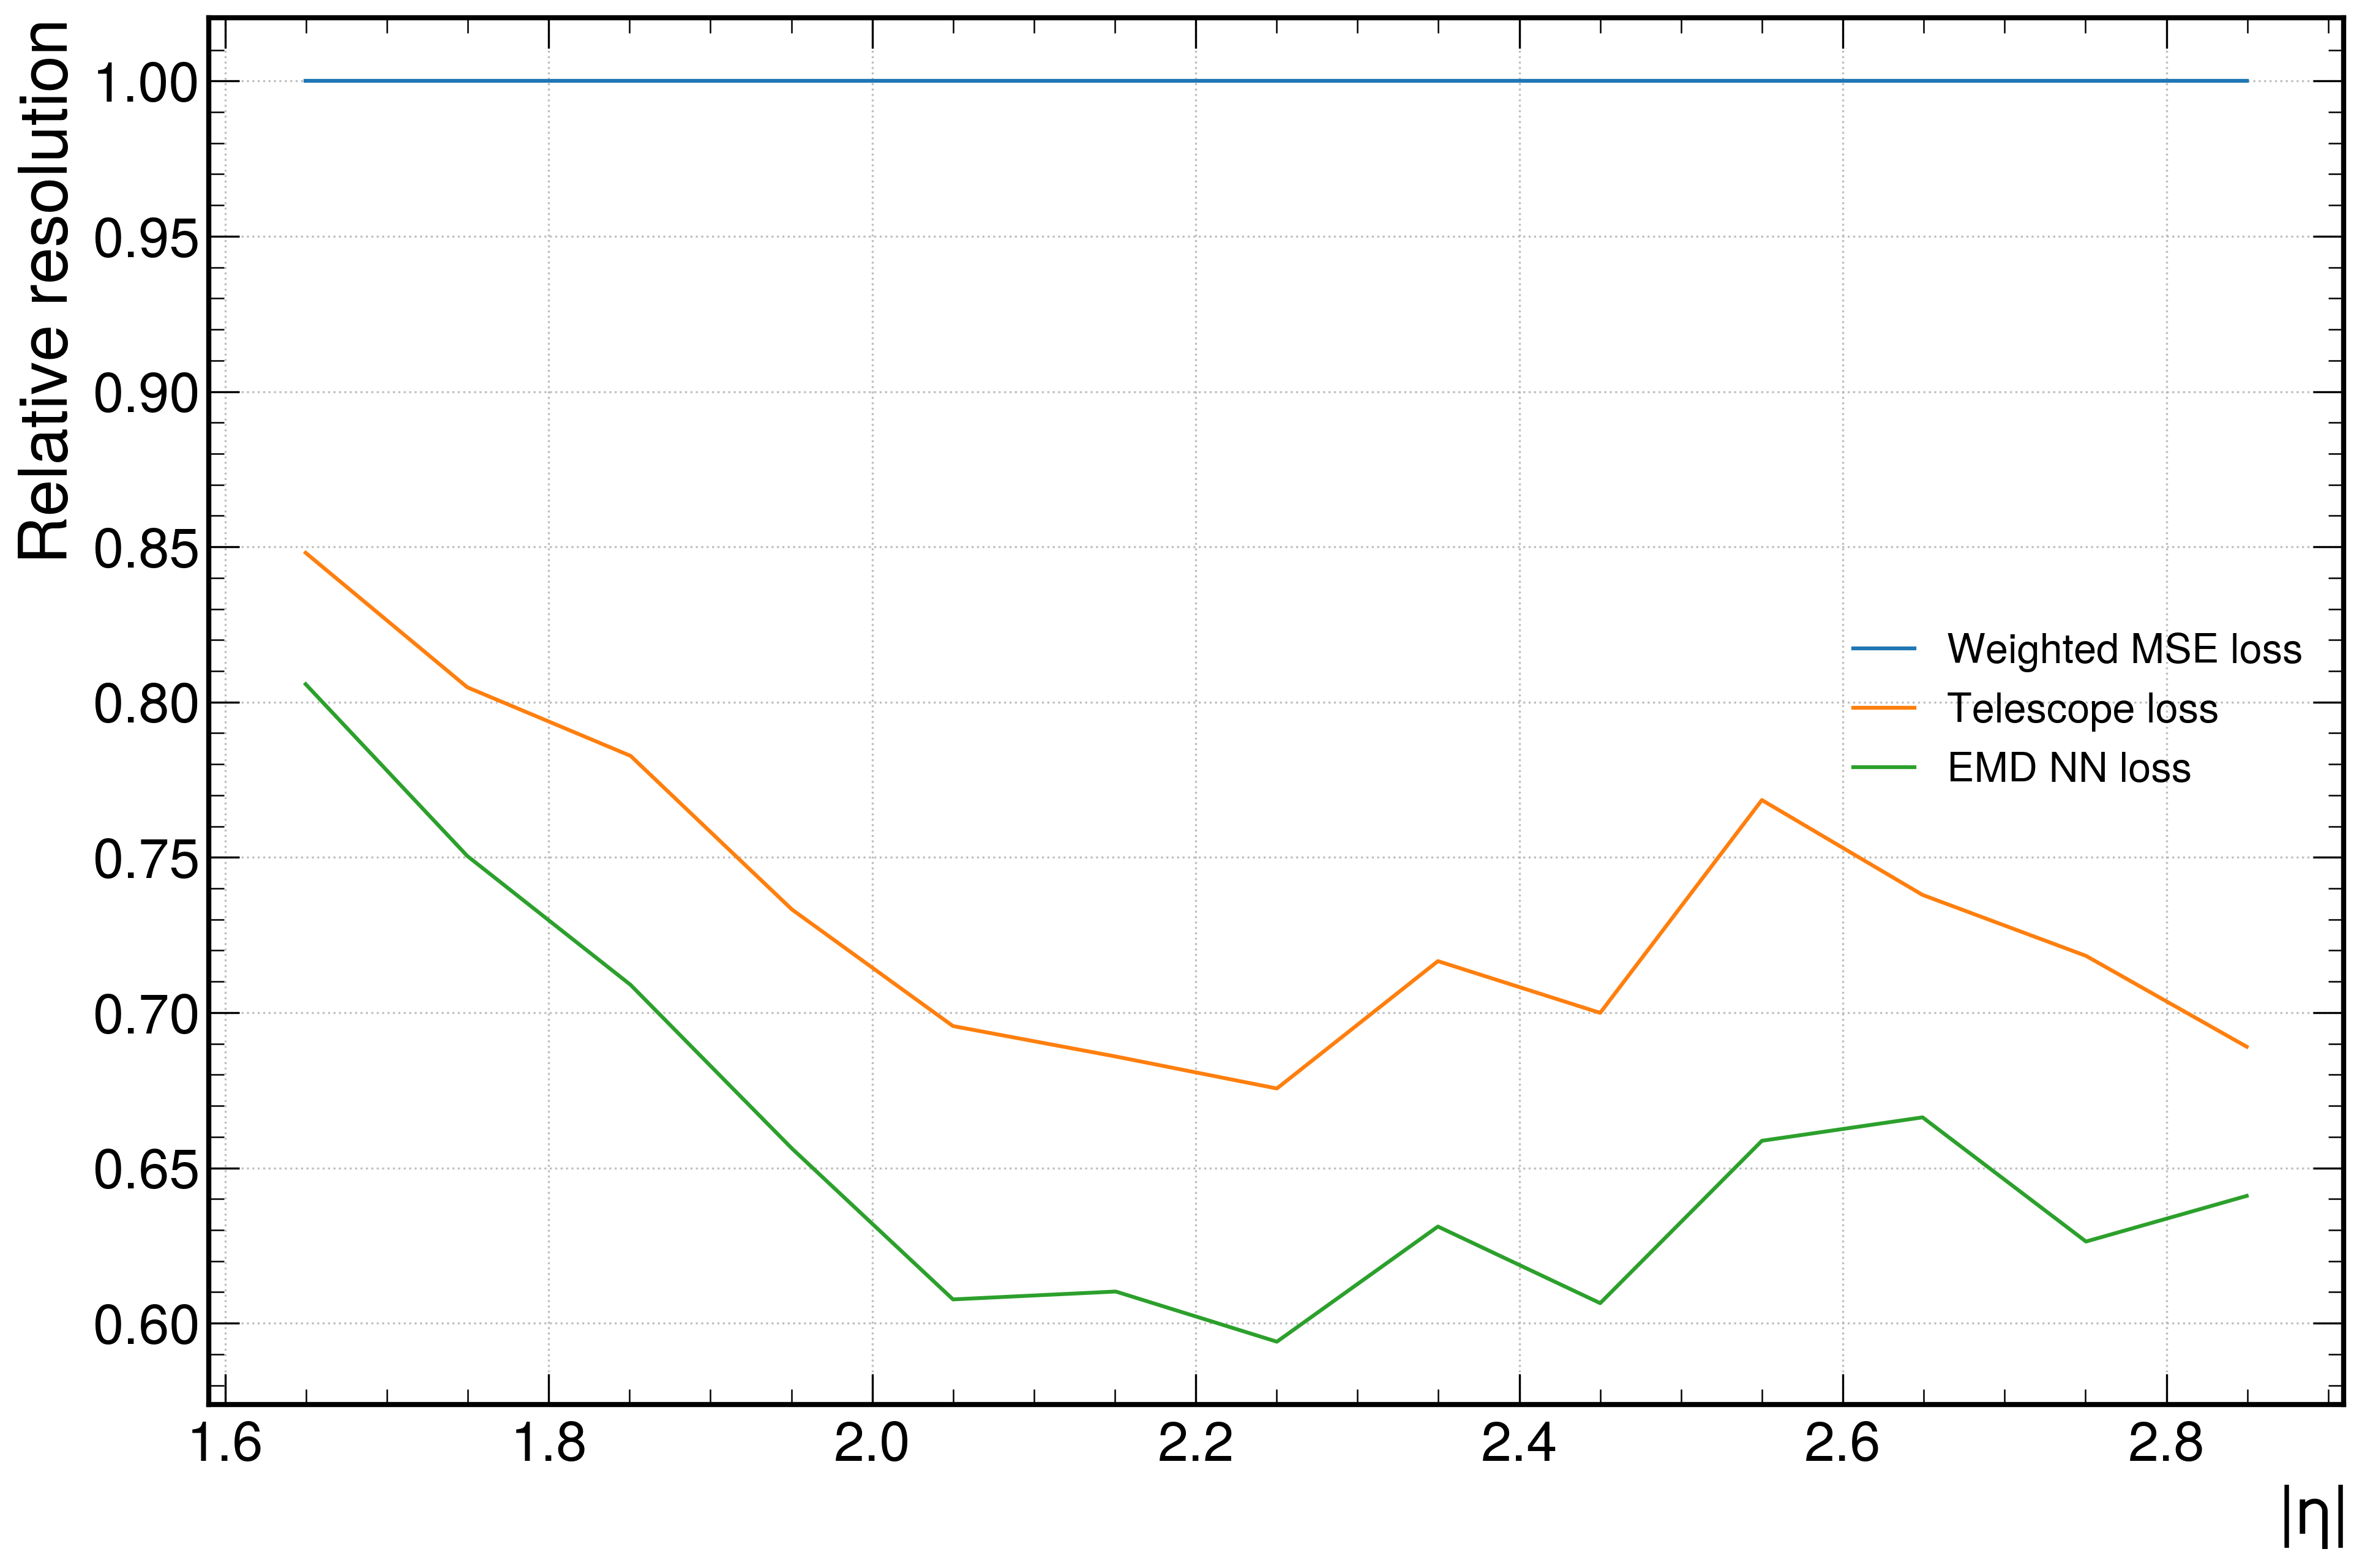

In [51]:
print('Relative resolution vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], (etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'])/DENOM_eta, color=colors[name], ls=styles[name], label=legends[name])
plt.legend(loc = 'center right', fontsize=16)
plt.xlabel(r'$|\eta|$')
#plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.ylabel('Relative resolution')
plt.grid()
#plt.savefig(fig_dir+'/ratio_res_v_eta.pdf')
plt.show()

Eff RMS vs pt


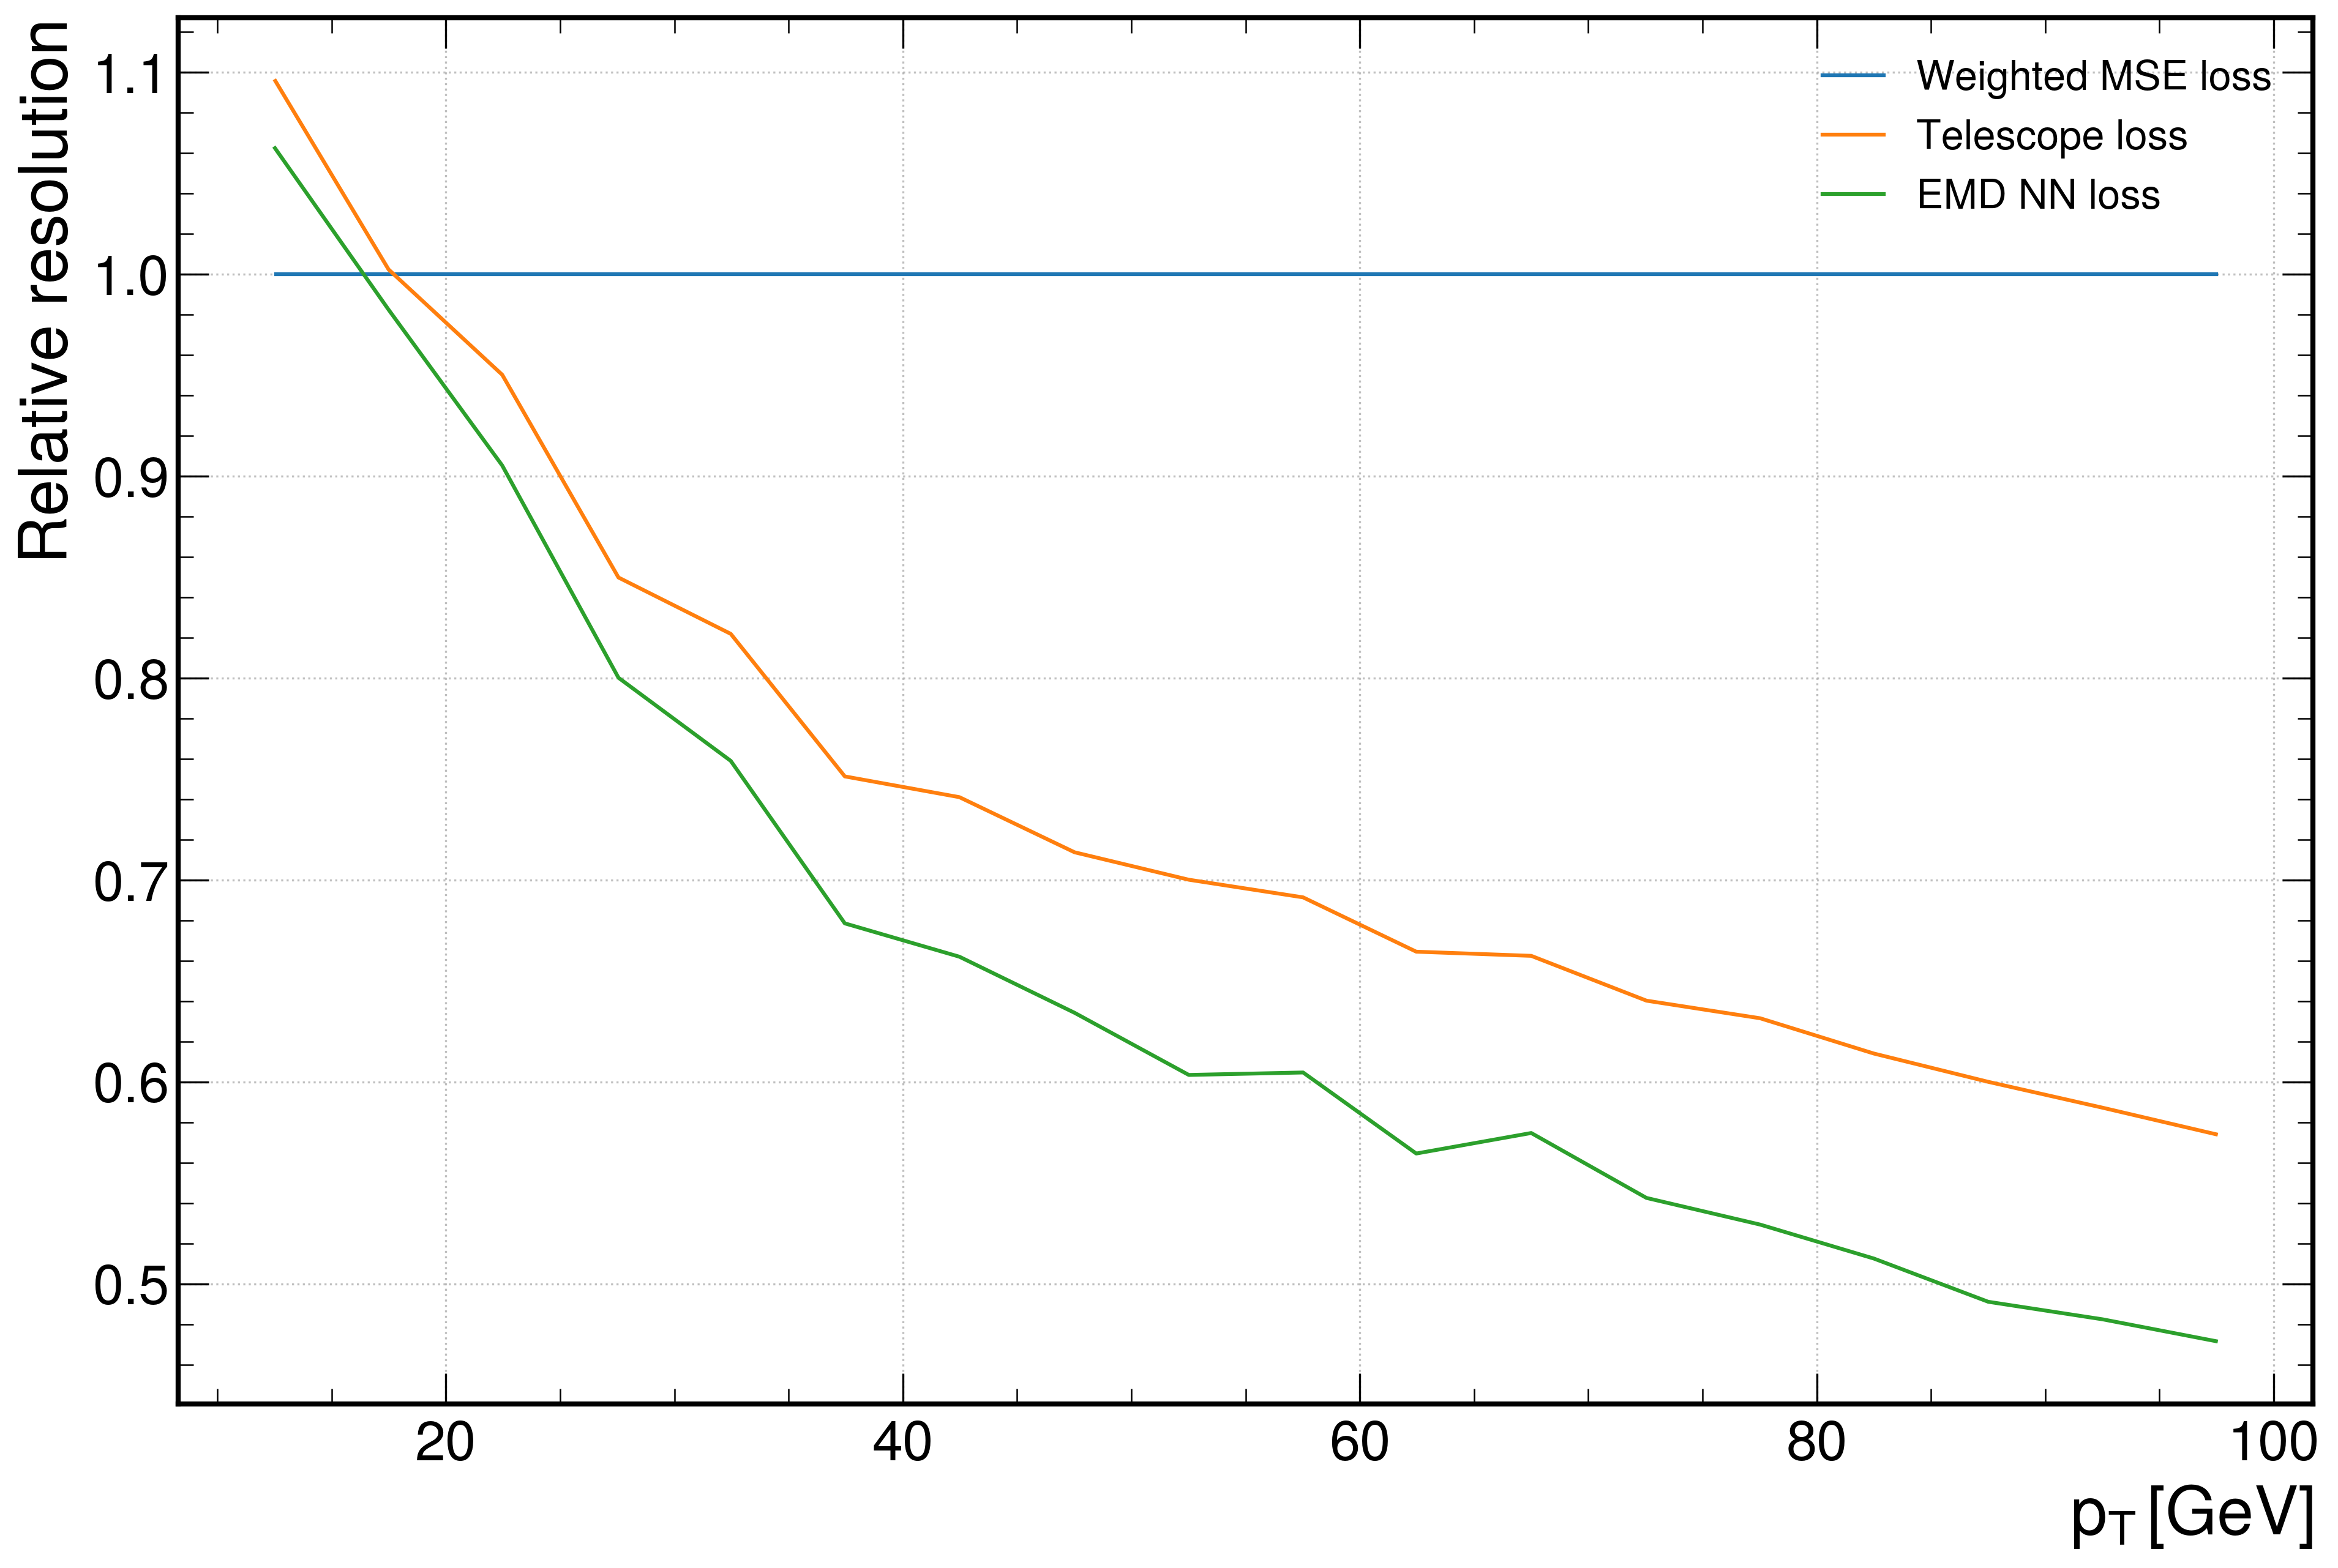

In [52]:
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], (pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'])/DENOM_pt, color=colors[name], ls=styles[name], label=legends[name])
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
#plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.ylabel('Relative resolution')
plt.grid()
plt.savefig(fig_dir+'/ratio_res_v_pT.pdf')
plt.show()